#Microsoft Azure predictive maintenance EDA and training


**Objective.** Explore and analyze the *Microsoft Azure Predictive Maintenance* dataset to assess Data Quality, generate relevant *features*, and establish modeling baselines.

**Deliverables of this notebook**
- Unification and data review
- Exploratory Data Analysis (EDA) (distributions, missing values, duplicates)
- Derivation of aggregated *features* by time window
- Key metrics and visualizations


## Table of Contents

1. Configuration and Imports
2. Data Loading
3. Merging and Preparation
4. Global EDA
5. Aggregations/Evaluation Windows
6. Model training
7. Baseline model description
8. Training with 2:1 balanced ratio
9. Explainability

## Configuration and Imports {#config}

In [31]:
import os
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import kagglehub
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_fscore_support
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_fscore_support, make_scorer
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
from scipy import sparse
import shap
import statsmodels.api as sm
from joblib import Memory



## Data Loading

In [2]:
# --------------------------------------------
# 1) Download dataset locally and define paths
# --------------------------------------------
# This downloads the latest available version of the dataset into a cache folder
DATASET_SLUG = "arnabbiswas1/microsoft-azure-predictive-maintenance"
path = kagglehub.dataset_download(DATASET_SLUG)
print("Dataset local path:", path)

# Expected file names within the dataset (CSV files)
FILES = {
    "machines":  "PdM_machines.csv",   # machineID, model, age
    "failures":  "PdM_failures.csv",   # datetime, machineID, failure
    "errors":    "PdM_errors.csv",     # datetime, machineID, errorID
    "maint":     "PdM_maint.csv",      # datetime, machineID, comp
    "telemetry": "PdM_telemetry.csv",  # datetime, machineID, voltage, rotation, pressure, vibration
}

Dataset local path: /kaggle/input/microsoft-azure-predictive-maintenance


### Merging and Preparation

In [3]:
# --------------------------------------------
# 2) Load all tables
# --------------------------------------------
# Note: parsing datetimes only for the tables that have a 'datetime' column
machines  = pd.read_csv(os.path.join(path, FILES["machines"]))
failures  = pd.read_csv(os.path.join(path, FILES["failures"]),  parse_dates=["datetime"])
errors    = pd.read_csv(os.path.join(path, FILES["errors"]),    parse_dates=["datetime"])
maint     = pd.read_csv(os.path.join(path, FILES["maint"]),     parse_dates=["datetime"])
telemetry = pd.read_csv(os.path.join(path, FILES["telemetry"]), parse_dates=["datetime"])

print("Shapes -> machines:", machines.shape,
      "| failures:", failures.shape,
      "| errors:", errors.shape,
      "| maint:", maint.shape,
      "| telemetry:", telemetry.shape)

# --------------------------------------------
# 2b) Quick peek at first row of each table
# --------------------------------------------
tables = {
    "machines": machines,
    "failures": failures,
    "errors": errors,
    "maint": maint,
    "telemetry": telemetry
}

for name, df in tables.items():
    print(f"\n===== {name.upper()} (shape={df.shape}) =====")
    print(df.head(1).to_string(index=False))

Shapes -> machines: (100, 3) | failures: (761, 3) | errors: (3919, 3) | maint: (3286, 3) | telemetry: (876100, 6)

===== MACHINES (shape=(100, 3)) =====
 machineID  model  age
         1 model3   18

===== FAILURES (shape=(761, 3)) =====
           datetime  machineID failure
2015-01-05 06:00:00          1   comp4

===== ERRORS (shape=(3919, 3)) =====
           datetime  machineID errorID
2015-01-03 07:00:00          1  error1

===== MAINT (shape=(3286, 3)) =====
           datetime  machineID  comp
2014-06-01 06:00:00          1 comp2

===== TELEMETRY (shape=(876100, 6)) =====
           datetime  machineID       volt     rotate   pressure  vibration
2015-01-01 06:00:00          1 176.217853 418.504078 113.077935  45.087686


### Data Quality

In [4]:
# --------------------------------------------
# Basic sanity checks
# --------------------------------------------
# Ensure key columns exist; raise clear errors early if not
required_cols = {
    "machines":  {"machineID", "model", "age"},
    "failures":  {"machineID", "failure", "datetime"},
    "errors":    {"machineID", "errorID", "datetime"},
    "maint":     {"machineID", "comp", "datetime"},
    "telemetry": {"machineID", "datetime", "volt", "rotate", "pressure", "vibration"},
}
tables = {
    "machines": machines, "failures": failures, "errors": errors,
    "maint": maint, "telemetry": telemetry
}
for name, req in required_cols.items():
    missing = req - set(tables[name].columns)
    if missing:
        raise ValueError(f"Table '{name}' is missing required columns: {missing}")
    else:
        print(f"Sanity check passed for table '{name}'.")

Sanity check passed for table 'machines'.
Sanity check passed for table 'failures'.
Sanity check passed for table 'errors'.
Sanity check passed for table 'maint'.
Sanity check passed for table 'telemetry'.


In [5]:
# ============================================
# Build RAW merged dataframe (df_brute)
#   - Base: telemetry (machineID + datetime)
#   - Add: failures (flag + type), errors (one-hot + count), maint (one-hot + count)
#   - Add: machines static info (model, age)
# ============================================

# --- Safety: ensure expected columns exist ---
required = {
    "machines":  {"machineID", "model", "age"},
    "failures":  {"machineID", "datetime", "failure"},
    "errors":    {"machineID", "datetime", "errorID"},
    "maint":     {"machineID", "datetime", "comp"},
    "telemetry": {"machineID", "datetime", "volt", "rotate", "pressure", "vibration"},
}
for name, req in required.items():
    missing = req - set(eval(name).columns)
    if missing:
        raise ValueError(f"Table '{name}' is missing columns: {missing}")

# --------------------------------------------
# A) Start from telemetry as the granular base
# --------------------------------------------
df_brute = telemetry.copy()

# Ensure sorting (helps later checks)
df_brute = df_brute.sort_values(["machineID", "datetime"]).reset_index(drop=True)

# --------------------------------------------
# B) Failures: add a binary flag and (optionally) failure type
#    Assumption: at most one failure per (machineID, datetime)
# --------------------------------------------
failures_flag = failures.copy()
failures_flag["failure_event"] = 1

# Merge failure_event (0/1)
df_brute = df_brute.merge(
    failures_flag[["machineID", "datetime", "failure_event"]],
    on=["machineID", "datetime"], how="left"
)
df_brute["failure_event"] = df_brute["failure_event"].fillna(0).astype(int)

# (Optional) If you want the categorical failure type (can be NaN when no event)
df_brute = df_brute.merge(
    failures[["machineID", "datetime", "failure"]].drop_duplicates(),
    on=["machineID", "datetime"], how="left"
)

# --------------------------------------------
# C) Errors: pivot to one-hot per timestamp to avoid row duplication
# --------------------------------------------
# Count per errorID at (machineID, datetime)
err_pivot = (
    errors
    .assign(count=1)
    .pivot_table(index=["machineID", "datetime"], columns="errorID", values="count", aggfunc="sum", fill_value=0)
    .add_prefix("error_")
    .reset_index()
)

# Total errors at that timestamp
err_pivot["error_count"] = err_pivot.filter(like="error_").sum(axis=1)

# Merge into base
df_brute = df_brute.merge(err_pivot, on=["machineID", "datetime"], how="left")

# Fill NaNs from timestamps with no errors
error_cols = [c for c in df_brute.columns if c.startswith("error_")]
df_brute[error_cols] = df_brute[error_cols].fillna(0).astype(int)

# --------------------------------------------
# D) Maintenance: pivot to one-hot per timestamp
# --------------------------------------------
mnt_pivot = (
    maint
    .assign(count=1)
    .pivot_table(index=["machineID", "datetime"], columns="comp", values="count", aggfunc="sum", fill_value=0)
    .add_prefix("maint_")
    .reset_index()
)

mnt_pivot["maint_count"] = mnt_pivot.filter(like="maint_").sum(axis=1)

df_brute = df_brute.merge(mnt_pivot, on=["machineID", "datetime"], how="left")

maint_cols = [c for c in df_brute.columns if c.startswith("maint_")]
df_brute[maint_cols] = df_brute[maint_cols].fillna(0).astype(int)

# --------------------------------------------
# E) Add static machine info (model, age)
# --------------------------------------------
df_brute = df_brute.merge(machines, on="machineID", how="left")

# --------------------------------------------
# F) Final ordering and quick sanity prints
# --------------------------------------------
ordered_cols = (
    ["machineID", "datetime", "model", "age"] +
    ["volt", "rotate", "pressure", "vibration"] +
    ["failure_event", "failure"] +
    error_cols + ["error_count"] +
    maint_cols + ["maint_count"]
)
# Keep only columns that exist (some error_/maint_ may vary)
df_brute = df_brute[[c for c in ordered_cols if c in df_brute.columns]]

print("df_brute shape:", df_brute.shape)
print("df_brute preview:\n", df_brute.head(5).to_string(index=False))

# --------------------------------------------
# G) Quick integrity checks
# --------------------------------------------
# Duplicates by (machineID, datetime)
dupes = df_brute.duplicated(subset=["machineID", "datetime"]).sum()
print("\nDuplicates (machineID, datetime):", dupes)

# Missing values snapshot
print("\nMissing values (top 15):")
print(df_brute.isna().sum().sort_values(ascending=False).head(15))

# Numeric summary (first 10 rows of describe)
print("\nNumeric summary (head):")
print(df_brute.select_dtypes(include=["number"]).describe().T.head(10))

df_brute shape: (876226, 23)
df_brute preview:
  machineID            datetime  model  age       volt     rotate   pressure  vibration  failure_event failure  error_error1  error_error2  error_error3  error_error4  error_error5  error_count  error_count  maint_comp1  maint_comp2  maint_comp3  maint_comp4  maint_count  maint_count
         1 2015-01-01 06:00:00 model3   18 176.217853 418.504078 113.077935  45.087686              0     NaN             0             0             0             0             0            0            0            0            0            0            0            0            0
         1 2015-01-01 07:00:00 model3   18 162.879223 402.747490  95.460525  43.413973              0     NaN             0             0             0             0             0            0            0            0            0            0            0            0            0
         1 2015-01-01 08:00:00 model3   18 170.989902 527.349825  75.237905  34.178847              

#### Building the merged base table (`df_brute`)

The raw dataset comes from five separate CSVs:

- **Machines** → Static information (ID, model, age).  
- **Telemetry** → Time-series sensor readings (volt, rotate, pressure, vibration).  
- **Failures** → Timestamps of component failures.  
- **Errors** → Timestamps of error codes (error1–error5).  
- **Maintenance** → Timestamps of maintenance events (comp1–comp4).  

Since each source has complementary information, we merge them into a **single wide table** (`df_brute`) with one row per `(machineID, datetime)`.

---

#### Steps in the merge process

1. **Start from telemetry**  
   Telemetry provides the finest granularity: hourly sensor values for each machine.  
   This becomes the backbone of the dataset.

2. **Add failures**  
   - `failure_event`: binary flag (0/1) indicating a failure at that timestamp.  
   - `failure`: categorical label with the failed component (comp1–comp4).  

3. **Add errors (one-hot encoded)**  
   - Each error type (`error1`–`error5`) becomes a separate binary column (`error_error1`, …).  
   - `error_count`: total number of errors at that timestamp.  

4. **Add maintenance (one-hot encoded)**  
   - Each component (`comp1`–`comp4`) becomes a binary column (`maint_comp1`, …).  
   - `maint_count`: total number of maintenance operations at that timestamp.  

5. **Add machine static info**  
   - `model`: machine model (categorical).  
   - `age`: age of the machine in years at the start of observation.  

---

#### Why so many variables?

By pivoting categorical events (`errorID`, `comp`) into one-hot columns and adding counts, the dataset expands from the 6 original telemetry variables to **~22 columns**.  

This design ensures that every relevant signal — **sensor readings, errors, maintenance, failures, and static attributes** — is aligned at the same timestamp, enabling consistent feature engineering and predictive modeling.  


In [6]:
# =========================================================
# Clean df_brute before any resampling/aggregation
# - Fix duplicate column names
# - Collapse duplicate keys (machineID, datetime)
# - Re-validate integrity
# =========================================================


# 0) Fix duplicated column names (error_count, maint_count)
cols = pd.Series(df_brute.columns)
# If duplicated, append numeric suffixes then normalize desired names
if cols.duplicated().any():
    cols = cols.where(~cols.duplicated(), cols + "_" + cols.groupby(cols).cumcount().astype(str))
    df_brute.columns = cols

# Unify intended names for counts (keep a single column each)
# (pick the first if multiple exist; sum them just in case)
error_count_cols = [c for c in df_brute.columns if c.startswith("error_count")]
maint_count_cols = [c for c in df_brute.columns if c.startswith("maint_count")]

if len(error_count_cols) > 1:
    df_brute["error_count"] = df_brute[error_count_cols].sum(axis=1)
    df_brute.drop(columns=[c for c in error_count_cols if c != "error_count"], inplace=True)

if len(maint_count_cols) > 1:
    df_brute["maint_count"] = df_brute[maint_count_cols].sum(axis=1)
    df_brute.drop(columns=[c for c in maint_count_cols if c != "maint_count"], inplace=True)

# 1) Detect true duplicates by key
dup_mask = df_brute.duplicated(subset=["machineID", "datetime"], keep=False)
dup_rows = df_brute[dup_mask]

print(f"Duplicate key rows BEFORE collapse: {dup_rows.shape[0]} "
      f"(unique keys: {dup_rows[['machineID','datetime']].drop_duplicates().shape[0]})")

# 2) Collapse duplicates:
#    - Sensors: keep first (should be identical for same timestamp) or mean as safe fallback
#    - Flags/one-hot: sum (multiple events same timestamp)
#    - failure_event: max (0/1)
#    - failure type: keep first non-null
#    - Static: model/age: first
sensor_cols = ["volt", "rotate", "pressure", "vibration"]
error_onehot = [c for c in df_brute.columns if c.startswith("error_") and c not in ["error_count"]]
maint_onehot = [c for c in df_brute.columns if c.startswith("maint_") and c not in ["maint_count"]]

agg_spec = {}

# sensors: mean
for c in sensor_cols:
    if c in df_brute.columns:
        agg_spec[c] = "mean"

# events one-hot: sum
for c in error_onehot + maint_onehot:
    agg_spec[c] = "sum"

# counts: sum
for c in ["error_count", "maint_count"]:
    if c in df_brute.columns:
        agg_spec[c] = "sum"

# failure_event: max
if "failure_event" in df_brute.columns:
    agg_spec["failure_event"] = "max"

# failure type: first non-null
if "failure" in df_brute.columns:
    agg_spec["failure"] = lambda s: s.dropna().iloc[0] if s.dropna().shape[0] > 0 else np.nan

# model, age: first
for c in ["model", "age"]:
    if c in df_brute.columns:
        agg_spec[c] = "first"

# Apply groupby aggregation
df_brute_clean = (
    df_brute
    .groupby(["machineID", "datetime"], as_index=False)
    .agg(agg_spec)
    .sort_values(["machineID", "datetime"])
    .reset_index(drop=True)
)

# 3) Post-clean checks
print("df_brute_clean shape:", df_brute_clean.shape)

dupes_after = df_brute_clean.duplicated(subset=["machineID","datetime"]).sum()
print("Duplicates AFTER collapse:", dupes_after)

# Quick NA snapshot (top 15)
print("\nMissing values (top 15):")
print(df_brute_clean.isna().sum().sort_values(ascending=False).head(15))

# Numeric summary sanity check
print("\nNumeric summary (head):")
print(df_brute_clean.select_dtypes(include=["number"]).describe().T.head(12))

# Ensure sensors within expected physical bounds (assertions as guards)
assert df_brute_clean["volt"].between(90, 270).all(), "Volt out of expected range"
assert df_brute_clean["rotate"].between(100, 800).all(), "Rotate out of expected range"
assert df_brute_clean["pressure"].between(40, 200).all(), "Pressure out of expected range"
assert df_brute_clean["vibration"].between(0, 100).all(), "Vibration out of expected range"

Duplicate key rows BEFORE collapse: 168 (unique keys: 42)
df_brute_clean shape: (876100, 21)
Duplicates AFTER collapse: 0

Missing values (top 15):
failure         875381
datetime             0
volt                 0
rotate               0
machineID            0
pressure             0
vibration            0
error_error2         0
error_error1         0
error_error4         0
error_error5         0
maint_comp1          0
error_error3         0
maint_comp2          0
maint_comp3          0
dtype: int64

Numeric summary (head):
                 count        mean        std         min         25%  \
machineID     876100.0   50.500000  28.866087    1.000000   25.750000   
volt          876100.0  170.777736  15.509114   97.333604  160.304927   
rotate        876100.0  446.605119  52.673886  138.432075  412.305714   
pressure      876100.0  100.858668  11.048679   51.237106   93.498181   
vibration     876100.0   40.385007   5.370361   14.877054   36.777299   
error_error1  876100.0    0.001

##Global EDA

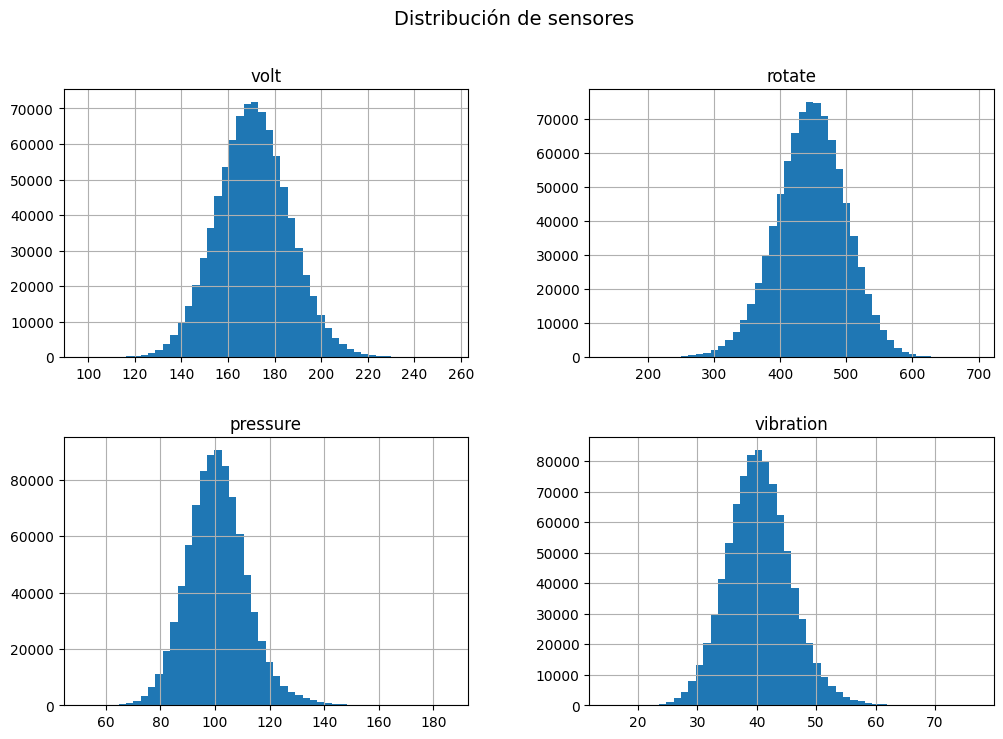

Total de fallos: 845

Fallos por componente:
failure
comp2    286
comp1    212
comp4    203
comp3    144
Name: count, dtype: int64


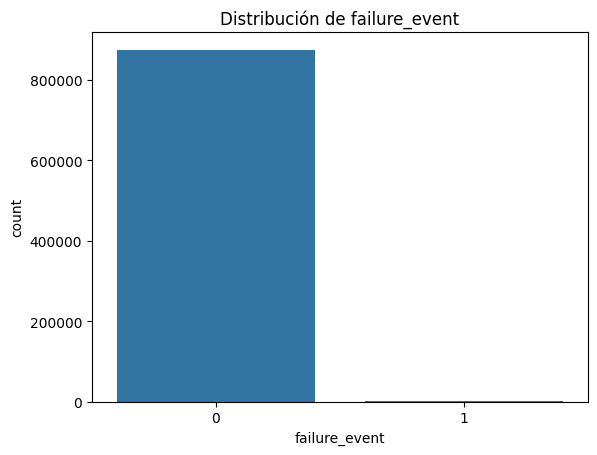


Errores totales:
error_error1    1013
error_error2     988
error_error3     838
error_error4     727
error_error5     356
error_count     7844
dtype: int64

Mantenimientos totales:
maint_comp1     761
maint_comp2     844
maint_comp3     744
maint_comp4     783
maint_count    6264
dtype: int64


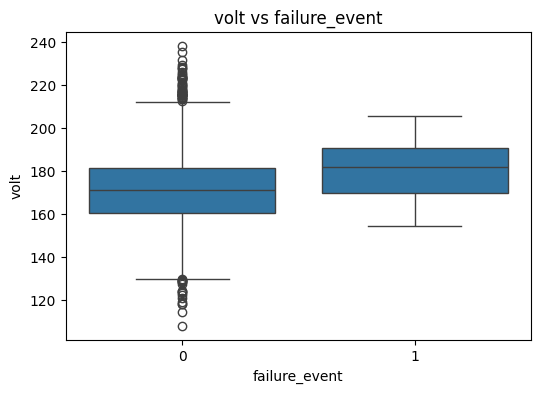

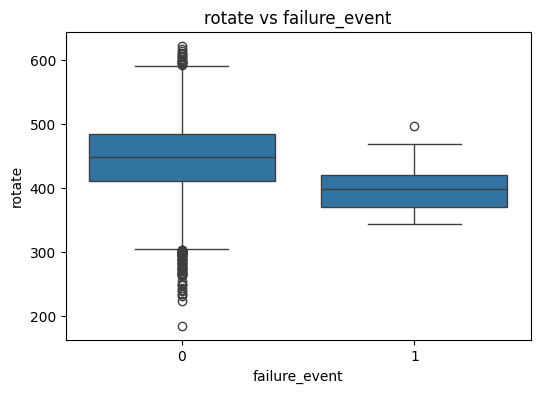

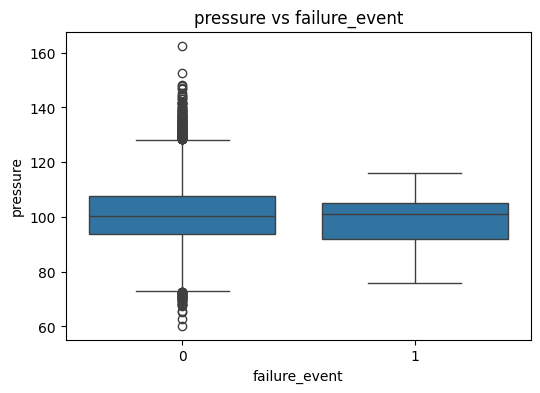

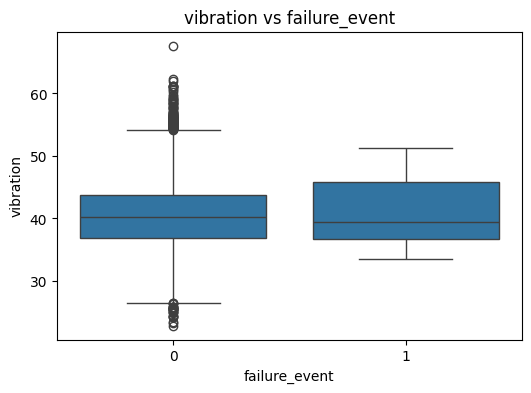

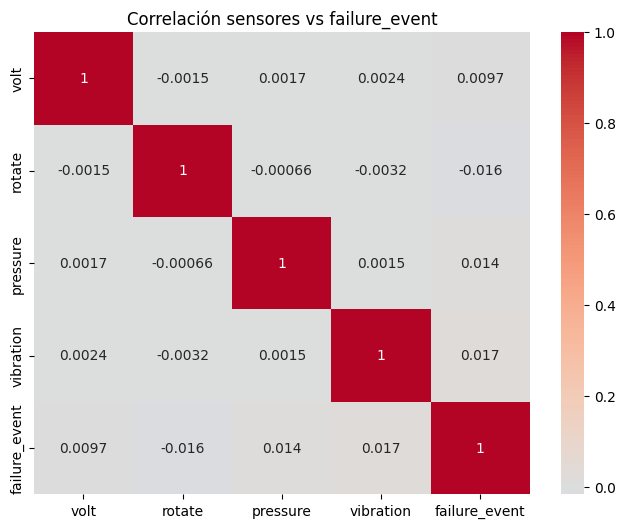

In [7]:
# ===============================
# 1) Distribución de sensores
# ===============================
sensor_cols = ["volt", "rotate", "pressure", "vibration"]

df_brute[sensor_cols].hist(bins=50, figsize=(12,8))
plt.suptitle("Distribución de sensores", fontsize=14)
plt.show()

# ===============================
# 2) Eventos de fallo
# ===============================
print("Total de fallos:", df_brute["failure_event"].sum())
print("\nFallos por componente:")
print(df_brute["failure"].value_counts(dropna=True))

sns.countplot(x="failure_event", data=df_brute)
plt.title("Distribución de failure_event")
plt.show()

# ===============================
# 3) Errores y mantenimientos
# ===============================
error_cols = [c for c in df_brute.columns if c.startswith("error_")]
maint_cols = [c for c in df_brute.columns if c.startswith("maint_")]

print("\nErrores totales:")
print(df_brute[error_cols].sum())

print("\nMantenimientos totales:")
print(df_brute[maint_cols].sum())

# ===============================
# 4) Sensores vs fallo
# ===============================
for col in sensor_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="failure_event", y=col, data=df_brute.sample(10000, random_state=42))
    plt.title(f"{col} vs failure_event")
    plt.show()

# ===============================
# 5) Correlaciones
# ===============================
plt.figure(figsize=(8,6))
sns.heatmap(df_brute[sensor_cols + ["failure_event"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación sensores vs failure_event")
plt.show()

**Sensor Correlation Analysis**

A basic EDA on the raw merged dataset shows that the absolute sensor values (volt, rotate, pressure, vibration) have almost zero linear correlation with the failure event (all |r| < 0.02). This indicates that direct sensor readings are not predictive of failures. Instead, predictive power must come from temporal features such as variability, ranges, rolling statistics, and event history (errors, maintenance, past failures). This motivated the feature engineering strategy that produced strong predictors, which later drove the logistic regression model to robust performance.

##Aggregations

####Logical Consistency for Agg

In [8]:
# ============================================
# Logical consistency checks before aggregation
# ============================================

print("Datetime range:", df_brute_clean["datetime"].min(), "→", df_brute_clean["datetime"].max())

# 1) Failure consistency
fail_mismatch = df_brute_clean.query("failure_event == 1 and failure.isna()")
print("\nRows where failure_event==1 but failure is NaN:", fail_mismatch.shape[0])

# 2) Failure_event vs error_count
fail_no_error = df_brute_clean.query("failure_event == 1 and error_count == 0")
print("Rows with failure_event==1 but error_count==0:", fail_no_error.shape[0])

# 3) Normalize failure column: NaN -> 0
df_brute_clean["failure"] = df_brute_clean["failure"].fillna(0)

# Sanity check counts
print("\nFailure_event distribution:")
print(df_brute_clean["failure_event"].value_counts())

print("\nFailure distribution (after fillna):")
print(df_brute_clean["failure"].value_counts())

Datetime range: 2015-01-01 06:00:00 → 2016-01-01 06:00:00

Rows where failure_event==1 but failure is NaN: 0
Rows with failure_event==1 but error_count==0: 716

Failure_event distribution:
failure_event
0    875381
1       719
Name: count, dtype: int64

Failure distribution (after fillna):
failure
0        875381
comp2       250
comp1       192
comp4       155
comp3       122
Name: count, dtype: int64


###Utils for Agg

In [9]:
import numpy as np
import pandas as pd

def make_features_target(
    df: pd.DataFrame,
    machine_col: str = "machineID",
    time_col: str = "datetime",
    failure_event_col: str = "failure_event",
    window_hours: int = 7 * 24,  # default: 7 days
    build_target: bool = True
) -> tuple[pd.DataFrame, list[str], str | None]:
    """
    Minimal reusable function to generate only the future target
    (fail_next_Xh or fail_next_Xd depending on the window).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least machine_col, time_col, failure_event_col.
    machine_col : str
        Machine identifier column.
    time_col : str
        Timestamp column (must be datetime-like).
    failure_event_col : str
        Column with failure events (0/1).
    window_hours : int
        Size of the forward-looking window in hours.
    build_target : bool
        Whether to compute the future target column.

    Returns
    -------
    df : pd.DataFrame
        Original dataframe plus target column (if build_target=True).
    feature_cols : list
        Empty list (no features are engineered here).
    target_col : str or None
        Name of the target column created, or None if not built.
    """
    df = df.copy()

    # --- Basic checks ---
    if time_col not in df.columns or machine_col not in df.columns:
        raise ValueError(f"Required columns missing: {time_col}, {machine_col}")
    if failure_event_col not in df.columns and build_target:
        raise ValueError(f"Missing '{failure_event_col}' to build target.")

    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    if df[time_col].isna().any():
        raise ValueError("NaT values found in time column.")

    # Stable ordering
    df = df.sort_values([machine_col, time_col], kind="mergesort").reset_index(drop=True)

    feature_cols: list[str] = []
    target_col: str | None = None

    # --- Optional future target ---
    if build_target:
        g = df.groupby(machine_col, sort=False)

        def _future_max(x: pd.Series) -> pd.Series:
            return x.shift(-1).rolling(window_hours, min_periods=1).max()

        # Decide suffix: days if divisible by 24, else hours
        if window_hours % 24 == 0:
            suf = f"{window_hours // 24}d"
        else:
            suf = f"{window_hours}h"

        target_col = f"fail_next_{suf}"
        df[target_col] = g[failure_event_col].transform(_future_max).fillna(0).astype(int)

    return df, feature_cols, target_col

###Daily Agg

In [10]:
# ======================================================
# Report class proportions
# ======================================================
df_24h, _, target_24h = make_features_target(df_brute_clean, window_hours=24)
print("Shape of df_24h:", df_24h.shape)
print("\nTarget distribution (%s):" % target_24h)
print(df_24h[target_24h].value_counts(normalize=True))


Shape of df_24h: (876100, 22)

Target distribution (fail_next_1d):
fail_next_1d
0    0.980328
1    0.019672
Name: proportion, dtype: float64


#### Class imbalance with 24h window

After generating features with a **24-hour past window** and predicting failures within the next 24 hours, the dataset shows a strong imbalance:

- **Shape:** 876,100 rows × 22 features  
- **Target distribution (fail_next_24h):**  
  - Class 0 → 98.03%  
  - Class 1 → 1.97%  

This indicates that failures in such a short horizon are rare, which makes it difficult for models to learn discriminative patterns without relying heavily on resampling or threshold adjustments.

### Next step: Increase prediction horizon

To address this, the strategy will be to **increase the prediction horizon (window size)**. By expanding the target to cover a longer period (e.g., 7 days, 14 days, or 30 days), we expect the proportion of positive cases to increase.  
This will provide a more balanced dataset, allowing models to better capture failure patterns without depending exclusively on synthetic sampling or undersampling.

The plan is to **iteratively test different window sizes** until reaching an **optimal balance between class distribution and dataset size**, ensuring both statistical robustness and model interpretability.


###Weekly Agg

In [11]:
# ======================================================
# Report class proportions
# ======================================================
df_7d, _, target_7d = make_features_target(df_brute_clean, window_hours=7*24)

print("Shape of df_7d:", df_7d.shape)
print("\nTarget distribution (%s):" % target_7d)
print(df_7d[target_7d].value_counts(normalize=True))

Shape of df_7d: (876100, 22)

Target distribution (fail_next_7d):
fail_next_7d
0    0.863969
1    0.136031
Name: proportion, dtype: float64


#### Class distribution with 7-day window

After generating only the **7-day future target** (without additional feature engineering), the dataset shows the following distribution:

- **Shape of `df_7d_eda`:** (876,100 rows × 22 feature)  
- **Target distribution (`fail_next_7d`):**  
  - Class 0 → 86.40%  
  - Class 1 → 13.60%  

This indicates that by expanding the prediction horizon from 24 hours to 7 days, the proportion of failure cases increases significantly. While the dataset remains imbalanced, the improvement compared to shorter horizons reduces the severity of the imbalance problem and provides a more informative signal for predictive modeling.  

---

### Next step: Evaluate larger windows

To further improve class balance and capture more meaningful temporal patterns, the strategy is to **test longer windows** (e.g., 14 days or 30 days). This iterative approach will help identify the **optimal trade-off** between class distribution and dataset size, ensuring robust statistical signals and better generalization for predictive maintenance models.  


###2 weeks Agg

In [12]:
# ======================================================
# Report class proportions
# ======================================================
df_14_eda, _, target_14d = make_features_target(df_brute_clean, window_hours=14*24)
print("Shape of df_14_eda:", df_14_eda.shape)
print("\nTarget distribution (%s):" % target_14d)
print(df_14_eda[target_14d].value_counts(normalize=True))


Shape of df_14_eda: (876100, 22)

Target distribution (fail_next_14d):
fail_next_14d
0    0.730538
1    0.269462
Name: proportion, dtype: float64


#### **Class distribution with 14-day window**

After generating features with a **14-day past window** and predicting failures within the next 14 days, the dataset shows a much healthier class balance:

- **Shape of `df_14_eda`:** (876,100 rows × 30 features)  
- **Target distribution (`fail_next_14d`):**  
  - Class 0 → 73.05%  
  - Class 1 → 26.95%  

This distribution represents a significant improvement compared to shorter horizons. With more than a quarter of the data labeled as failure events, the imbalance is no longer critical. Such a ratio is generally considered sufficient for training predictive models without requiring aggressive resampling strategies.  


####**Feature engineering**

##### **Engineered Features with 14-day Rolling Window**

The function `make_features_14d` generates aggregated variables using a **14-day rolling window** for each machine. These features capture recent operational patterns, maintenance activity, and failure history.

#### **Sensor-based features (per variable: `volt`, `rotate`, `pressure`, `vibration`)**
For each sensor column, the following statistics are created over the last 14 days:

- **`{col}_min_14d`**: Minimum observed value.  
- **`{col}_max_14d`**: Maximum observed value.  
- **`{col}_mean_14d`**: Mean value.  
- **`{col}_std_14d`**: Standard deviation (variability).  
- **`{col}_range_14d`**: Difference between max and min.  
- **`{col}_rstd_14d`**: Relative standard deviation (std/mean), normalized measure of variability.  

These features capture the magnitude and variability of sensor signals within the window.

---

#### **Error-related features**
- **`error_count_14d`**: Total number of recorded error events


In [13]:
# -------------------------------------------------------
# 1) Feature/target generator over a rolling window
# -------------------------------------------------------
def make_features_14d(
    df: pd.DataFrame,
    *,
    machine_col: str = "machineID",
    time_col: str = "datetime",
    failure_event_col: str = "failure_event",
    sensor_cols: list[str] | None = None,
    error_prefix: str = "error_",
    maint_prefix: str = "maint_",
    window_hours: int = 14 * 24,   # 14 days * 24 hours
    build_target: bool = True
) -> tuple[pd.DataFrame, list[str], str | None]:
    """
    Build aggregated features over a rolling window and optionally the target fail_next_{suffix}.
    - Avoids redundancy: excludes binary flags and days_since_last_maint.
    """
    df = df.copy()

    # Basic checks
    if time_col not in df.columns or machine_col not in df.columns:
        raise ValueError(f"Missing required columns: {time_col}, {machine_col}")
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    if df[time_col].isna().any():
        raise ValueError("There are NaT values in the time column.")

    df = df.sort_values([machine_col, time_col], kind="mergesort").reset_index(drop=True)

    # Suffix for column names
    suf = f"{window_hours//24}d" if window_hours % 24 == 0 else f"{window_hours}h"

    # Identify columns
    if sensor_cols is None:
        candidate_sensors = ["volt", "rotate", "pressure", "vibration"]
        sensor_cols = [c for c in candidate_sensors if c in df.columns]
    error_cols = [c for c in df.columns if c.startswith(error_prefix)]
    maint_cols = [c for c in df.columns if c.startswith(maint_prefix)]

    feature_cols: list[str] = []
    g = df.groupby(machine_col, sort=False)

    # Rolling statistics for sensor values
    for col in sensor_cols:
        roll = g[col].transform
        rmin  = roll(lambda x: x.rolling(window_hours, min_periods=1).min())
        rmax  = roll(lambda x: x.rolling(window_hours, min_periods=1).max())
        rmean = roll(lambda x: x.rolling(window_hours, min_periods=1).mean())
        rstd  = roll(lambda x: x.rolling(window_hours, min_periods=1).std(ddof=0))

        df[f"{col}_min_{suf}"]   = rmin
        df[f"{col}_max_{suf}"]   = rmax
        df[f"{col}_mean_{suf}"]  = rmean
        df[f"{col}_std_{suf}"]   = rstd.fillna(0.0)
        df[f"{col}_range_{suf}"] = rmax - rmin
        df[f"{col}_rstd_{suf}"]  = np.where(rmean.abs() > 1e-8, df[f"{col}_std_{suf}"] / rmean, 0.0)

        feature_cols += [
            f"{col}_min_{suf}", f"{col}_max_{suf}", f"{col}_mean_{suf}",
            f"{col}_std_{suf}", f"{col}_range_{suf}", f"{col}_rstd_{suf}"
        ]

    # Recent errors (count only)
    if error_cols:
        roll_errors = g[error_cols].transform(lambda x: x.rolling(window_hours, min_periods=1).sum())
        df[f"error_count_{suf}"] = roll_errors.sum(axis=1)
    else:
        df[f"error_count_{suf}"] = 0
    feature_cols += [f"error_count_{suf}"]

    # Recent maintenance (count only)
    if maint_cols:
        roll_maint = g[maint_cols].transform(lambda x: x.rolling(window_hours, min_periods=1).sum())
        df[f"maint_count_{suf}"] = roll_maint.sum(axis=1)
    else:
        df[f"maint_count_{suf}"] = 0
    feature_cols += [f"maint_count_{suf}"]

    # Machine age (days since first observation)
    install_date = g[time_col].transform("min")
    df["age_days"] = (df[time_col] - install_date).dt.days.astype(float)
    feature_cols += ["age_days"]

    # Past cumulative failures
    if failure_event_col in df.columns:
        df["past_failures"] = g[failure_event_col].cumsum().shift(1).fillna(0).astype(float)
    else:
        df["past_failures"] = 0.0
    feature_cols += ["past_failures"]

    # Error/Maintenance ratio (smoothed with +1)
    df[f"error_per_maint_{suf}"] = df[f"error_count_{suf}"] / (df[f"maint_count_{suf}"] + 1.0)
    feature_cols += [f"error_per_maint_{suf}"]

    # Target: fail_next_{suf}
    target_col: str | None = None
    if build_target:
        if failure_event_col not in df.columns:
            raise ValueError(f"Column '{failure_event_col}' not found to build target.")

        def _future_max(x: pd.Series) -> pd.Series:
            return x.shift(-1).rolling(window_hours, min_periods=1).max()

        df[f"fail_next_{suf}"] = g[failure_event_col].transform(_future_max).fillna(0).astype(int)
        target_col = f"fail_next_{suf}"

    return df, feature_cols, target_col



Shape of df_14_eda: (876100, 30)

Target distribution (fail_next_14d):
fail_next_14d
0    0.730538
1    0.269462
Name: proportion, dtype: float64

NaN counts per column (only >0):
No NaNs found


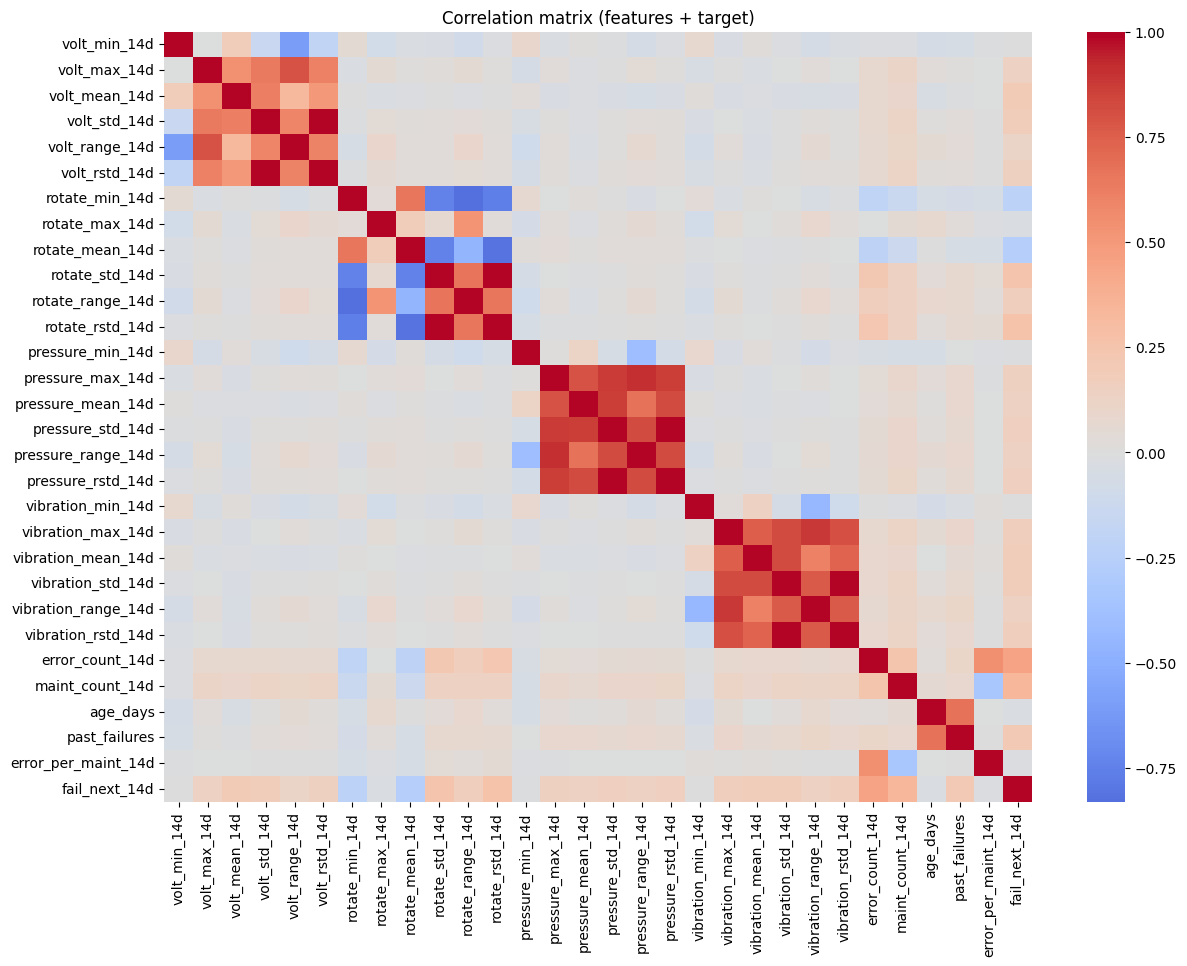


mean differences between classes:
fail_next_14d                 0           1       diff
rotate_range_14d     298.233406  311.971534  13.738129
error_count_14d        3.398868    7.237686   3.838818
pressure_range_14d    61.554757   64.730529   3.175771
pressure_max_14d     132.626822  135.720326   3.093504
volt_max_14d         215.666583  218.331318   2.664735
volt_range_14d        88.979379   91.572464   2.593085
rotate_std_14d        51.374422   53.861321   2.486899
maint_count_14d        2.855855    5.318609   2.462754
past_failures          3.370728    4.808977   1.438248
vibration_max_14d     55.828055   57.245794   1.417739
vibration_range_14d   30.231565   31.643689   1.412123
volt_mean_14d        170.584622  171.343352   0.758730
pressure_mean_14d    100.693272  101.318361   0.625089
pressure_std_14d      10.612199   11.190730   0.578532
volt_std_14d          15.269609   15.668830   0.399221
vibration_mean_14d    40.300280   40.621960   0.321681
vibration_std_14d      5.21387

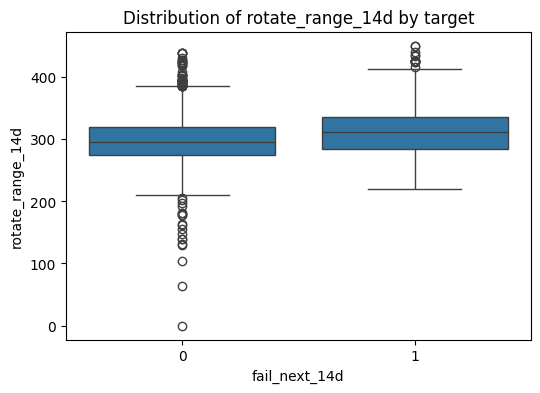

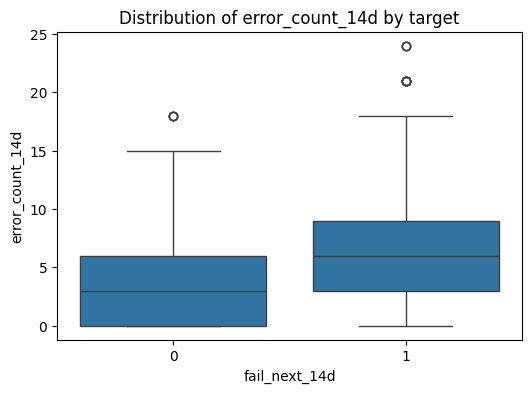

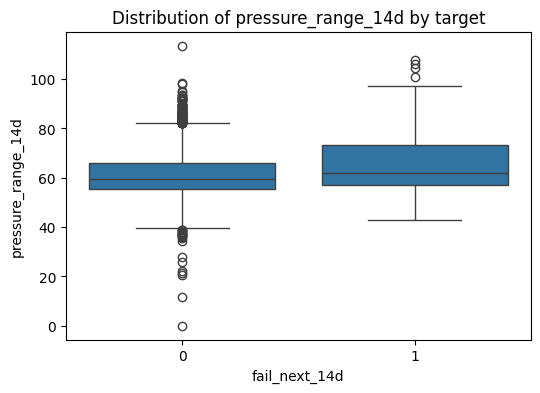

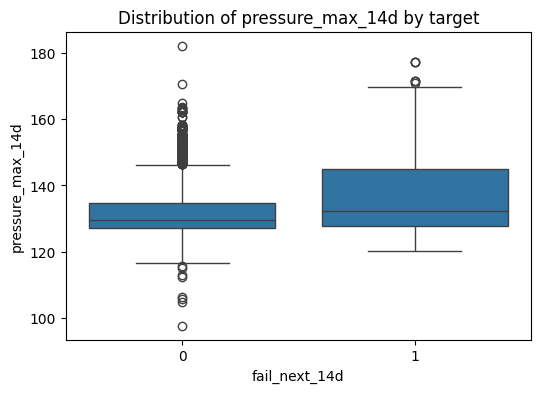

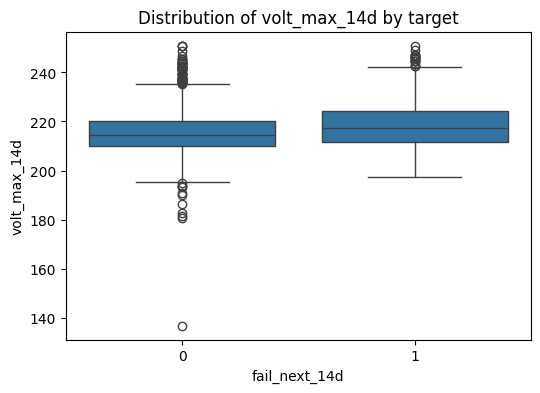

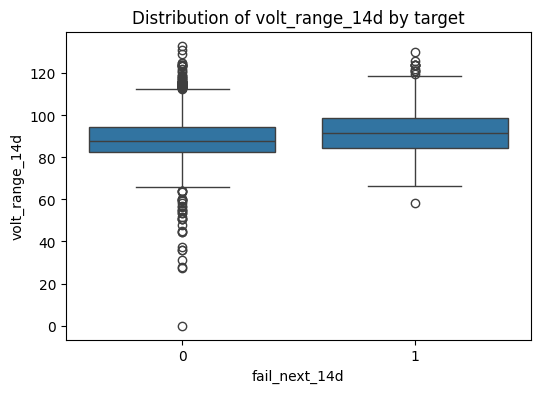

In [14]:
# ======================================================
# Generate df_14_agg from df_brute_clean
# ======================================================
df_14_agg, feat_cols, target_col = make_features_14d(
    df_brute_clean,
    build_target=True
)

# For EDA we only use features and target
df_14_eda = df_14_agg[feat_cols + [target_col]].copy()

print("\nShape of df_14_eda:", df_14_eda.shape)
print("\nTarget distribution (fail_next_14d):")
print(df_14_eda[target_col].value_counts(normalize=True))

# ======================================================
# NaN counts (sanity check)
# ======================================================
nan_counts = df_14_eda.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)

print("\nNaN counts per column (only >0):")
print(nan_counts if not nan_counts.empty else "No NaNs found")

# ======================================================
# Correlations (Pearson to check linearity)
# ======================================================
corr = df_14_eda[feat_cols + [target_col]].corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation matrix (features + target)")
plt.show()

# ======================================================
# Relationship between features and target
# ======================================================
# Mean values of each feature by target class (0 vs 1)
means_by_target = df_14_eda.groupby(target_col)[feat_cols].mean().T
means_by_target["diff"] = means_by_target[1] - means_by_target[0]
means_by_target = means_by_target.sort_values("diff", ascending=False)

print("\nmean differences between classes:")
print(means_by_target)

# ======================================================
# Boxplots to visualize linear separability
# ======================================================
top_feats = means_by_target.head(6).index.tolist()  # top 6 most discriminative features

for col in top_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df_14_eda.sample(5000, random_state=42))  # sample for performance
    plt.title(f"Distribution of {col} by target")
    plt.show()


#### Feature relevance signals

Preliminary univariate analysis shows that several aggregated features exhibit meaningful differences between classes. In particular:  

- **Rotate range (+13.7)**, **error count (+3.8)**, and **pressure range (+3.2)** are higher on average for failing machines.  
- Maintenance-related signals such as **maint_count (+2.5)** and **past_failures (+1.4)** also show clear separation.  
- Sensor dynamics (**rotate_std**, **vibration_max**, **pressure_max**) display consistent but smaller shifts.  
- Some variables (e.g., **volt_min**, **pressure_min**, **vibration_min**) show almost no difference between classes.  
- A few features, like **rotate_min (-14.9)** and **age_days (-6.2)**, move in the opposite direction, suggesting potential inverse relationships.  

This highlights that both operational variability (ranges, standard deviations) and historical usage (errors, maintenance, failures) contribute useful predictive signals.  

---

#### Next step: Begin modeling experiments

At this stage, the class proportions are **healthy enough to start experimentation with different algorithms**. Leveraging the 14-day window allows models to capture richer signals from error and maintenance history while preserving a large base of non-failure cases, enabling statistically robust training and interpretable results.  


####Multicollinearity check

In [15]:
target = "fail_next_14d"

# -------------------------------------------------------------------
# Build the full numeric candidate set
# -------------------------------------------------------------------
candidates = (
    df_14_eda
    .drop(columns=[target], errors="ignore")
    .select_dtypes(include=[np.number])
    .copy()
)

# Replace +/- inf with NaN to avoid exploding VIF
candidates.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop quasi-constant columns
zero_var_cols = [c for c in candidates.columns if candidates[c].nunique(dropna=True) <= 1]
if zero_var_cols:
    candidates.drop(columns=zero_var_cols, inplace=True)

# Drop columns with too many NaN (tune the threshold)
MAX_NA_FRAC = 0.30
na_frac = candidates.isna().mean()
high_na_cols = na_frac[na_frac > MAX_NA_FRAC].index.tolist()
if high_na_cols:
    candidates.drop(columns=high_na_cols, inplace=True)

# Simple median imputation ONLY for the VIF math (not for your final model)
candidates_vif = candidates.fillna(candidates.median(numeric_only=True))

# -------------------------------------------------------------------
# VIF helpers
# -------------------------------------------------------------------
def compute_vif(df_num: pd.DataFrame) -> pd.Series:
    """
    Compute VIF for each column in df_num.
    """
    X = sm.add_constant(df_num, has_constant="add")
    vifs = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns
    )
    return vifs.drop("const", errors="ignore")

def stepwise_vif(df_num: pd.DataFrame, threshold: float = 10.0, verbose: bool = True):
    """
    Iteratively drop the column with the highest VIF until all VIFs <= threshold.
    Returns: (kept_columns, final_vif_series, dropped_list)
    """
    X = df_num.copy()
    dropped = []
    while X.shape[1] > 2:
        v = compute_vif(X)
        max_feat, max_val = v.idxmax(), float(v.max())
        if max_val <= threshold:
            return X.columns.tolist(), v.sort_values(ascending=False), dropped
        if verbose:
            print(f"Dropping {max_feat} (VIF={max_val:.2f})")
        dropped.append((max_feat, max_val))
        X = X.drop(columns=[max_feat])

    return X.columns.tolist(), compute_vif(X), dropped

# -------------------------------------------------------------------
# Run stepwise VIF over the FULL candidate set
# -------------------------------------------------------------------
VIF_THRESHOLD = 5.0
keep_cols, final_vif, dropped = stepwise_vif(candidates_vif, threshold=VIF_THRESHOLD, verbose=True)

print("\nKept features after VIF:")
print(keep_cols)

print("\nFinal VIF values:")
print(final_vif)

print("\nDropped (feature, VIF_when_dropped):")
print(pd.DataFrame(dropped, columns=["feature", "VIF_when_dropped"]))

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping volt_min_14d (VIF=inf)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping rotate_min_14d (VIF=inf)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping pressure_min_14d (VIF=inf)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping vibration_min_14d (VIF=inf)
Dropping volt_std_14d (VIF=1868.08)
Dropping pressure_std_14d (VIF=1774.26)
Dropping rotate_rstd_14d (VIF=1470.40)
Dropping vibration_std_14d (VIF=1074.29)
Dropping pressure_max_14d (VIF=9.56)
Dropping vibration_max_14d (VIF=7.03)
Dropping pressure_rstd_14d (VIF=5.48)

Kept features after VIF:
['volt_max_14d', 'volt_mean_14d', 'volt_range_14d', 'volt_rstd_14d', 'rotate_max_14d', 'rotate_mean_14d', 'rotate_std_14d', 'rotate_range_14d', 'pressure_mean_14d', 'pressure_range_14d', 'vibration_mean_14d', 'vibration_range_14d', 'vibration_rstd_14d', 'error_count_14d', 'maint_count_14d', 'age_days', 'past_failures', 'error_per_maint_14d']

Final VIF values:
volt_max_14d           3.654633
vibration_rstd_14d     3.491614
rotate_range_14d       3.351324
volt_range_14d         3.239326
rotate_std_14d         3.225686
rotate_mean_14d        2.639829
vibration_range_14d    2.563606
vibration_mean_14d     2.292913
error_per_maint_14d    2.154232
error_count_14d  

##### Variance Inflation Factor (VIF) – Interpretation

- **Formula:** `VIF = 1 / (1 − R²)`  
- **Meaning:** VIF measures how much a feature is explained by the others.  
- **Thresholds (rule of thumb):**  
  - `VIF = 1` → no collinearity.  
  - `VIF ≈ 5` → feature can be ~80% explained by the rest (`R² ≥ 0.8`).  
  - `VIF > 10` → severe multicollinearity.  

In this project we use the stricter criterion **VIF ≤ 5** to ensure stability and interpretability of coefficients.

---

##### VIF ≤ 5

To keep coefficients stable and explanations reliable, we ran VIF on the **entire numeric feature space** (no pre-filtering) with three safeguards:

1. **Data hygiene:** replace `∞`/`NaN`, drop constants, and remove columns with excessive missingness for the VIF computation.  
2. **Exact-identity pruning:** remove linear triads within sensor families (e.g., `max = min + range`) that cause perfect multicollinearity (`VIF = ∞`).  
3. **Stepwise VIF (threshold = 5):** iteratively drop the feature with the highest VIF until all VIFs ≤ 5.

---

##### What the stepwise VIF removed
1. **Perfect multicollinearity (VIF = ∞):**  
   - `volt_min_14d`, `rotate_min_14d`, `pressure_min_14d`, `vibration_min_14d`  
   (these belong to linear triads with `max` and `range`).

2. **Near-linear redundancy (VIF in the thousands):**  
   - `volt_std_14d` (1868.08)  
   - `pressure_std_14d` (1774.26)  
   - `rotate_rstd_14d` (1470.40)  
   - `vibration_std_14d` (1074.29)

3. **Above-threshold (VIF > 5 under the stricter criterion):**  
   - `pressure_max_14d` (9.56)  
   - `vibration_max_14d` (7.03)  
   - `pressure_rstd_14d` (5.48)  



#### **low-variance check**

In [16]:
# -------------------------------------------------------------------
# Post-VIF pruning: drop near-constant / low-variance features
# -------------------------------------------------------------------
# We assess *original (non-imputed)* candidates, restricted to VIF-kept cols
kept_numeric = candidates[keep_cols].copy()

# Thresholds (tune as needed)
MIN_UNIQUE_FRAC = 0.01   # <1% distinct values → quasi-constant
MIN_STD         = 1e-3   # extremely low dispersion

n_rows = len(kept_numeric)
unique_frac = kept_numeric.nunique(dropna=True) / max(n_rows, 1)
std_vals    = kept_numeric.std(numeric_only=True)

low_var_cols = sorted(list(set(
    unique_frac[unique_frac <= MIN_UNIQUE_FRAC].index.tolist()
    + std_vals[std_vals <= MIN_STD].index.tolist()
)))

print(f"\nLow-variance detected (|unique|/N ≤ {MIN_UNIQUE_FRAC} OR std ≤ {MIN_STD}):")
print(low_var_cols if low_var_cols else "None")

# Final feature list after VIF + low-variance filters
final_cols = [c for c in keep_cols if c not in low_var_cols]

print("\nFinal feature count:", len(final_cols))
print("Final features:", final_cols)

# Build final EDA frame (features + target)
df_model = df_14_eda[final_cols + [target]].copy()
print("\nShape of df_model:", df_model.shape)



Low-variance detected (|unique|/N ≤ 0.01 OR std ≤ 0.001):
['age_days', 'error_count_14d', 'error_per_maint_14d', 'maint_count_14d', 'past_failures', 'rotate_max_14d', 'volt_max_14d']

Final feature count: 11
Final features: ['volt_mean_14d', 'volt_range_14d', 'volt_rstd_14d', 'rotate_mean_14d', 'rotate_std_14d', 'rotate_range_14d', 'pressure_mean_14d', 'pressure_range_14d', 'vibration_mean_14d', 'vibration_range_14d', 'vibration_rstd_14d']

Shape of df_model: (876100, 12)


#### **Near-constant / low-variance features**

After removing multicollinearity with stepwise VIF (threshold `VIF ≤ 5`), we apply a **variance-based cleanup** on the remaining numeric features:

- **Quasi-constant check:** drop variables with a distinct-value ratio below 1%  
  (`|unique| / N ≤ 0.01`), as they carry little signal across observations.
- **Dispersion check:** drop variables with **very low standard deviation**  
  (`std ≤ 1e-3`), indicating negligible variation.

---

### Features removed due to low variance
The following variables were flagged as **near-constant** or with negligible dispersion:  

- `age_days`  
- `error_count_14d`  
- `error_per_maint_14d`  
- `maint_count_14d`  
- `past_failures`  
- `rotate_max_14d`  
- `volt_max_14d`  

These features add little new information and risk introducing noise or instability.

---

### Final retained set
After both **VIF filtering** and **variance-based pruning**, the final modeling set contains **11 features**:

- `volt_mean_14d`, `volt_range_14d`, `volt_rstd_14d`  
- `rotate_mean_14d`, `rotate_std_14d`, `rotate_range_14d`  
- `pressure_mean_14d`, `pressure_range_14d`  
- `vibration_mean_14d`, `vibration_range_14d`, `vibration_rstd_14d`  

---

### Final dataset
- **Shape of `df_model`:** (876,100 rows × 12 columns, including target)  
- **Composition:** 11 engineered features + 1 target (`fail_next_14d`)  

This reduced feature space ensures a **stable, interpretable, and non-redundant** foundation for predictive modeling.



### Final retained set
- All remaining features have **VIF ≤ 3.65**, ensuring a well-conditioned feature space for modeling.


In [17]:

# Build df_model
print("Shape of df_model:", df_model.shape)
print("\nTarget distribution:")
print(df_model[target].value_counts(normalize=True))

print("\nFirst rows:")
print(df_model.head())

Shape of df_model: (876100, 12)

Target distribution:
fail_next_14d
0    0.730538
1    0.269462
Name: proportion, dtype: float64

First rows:
   volt_mean_14d  volt_range_14d  volt_rstd_14d  rotate_mean_14d  \
0     176.217853        0.000000       0.000000       418.504078   
1     169.548538       13.338630       0.039336       410.625784   
2     170.028993       13.338630       0.032275       449.533798   
3     168.137453       13.755020       0.034331       423.687682   
4     166.031967       18.607832       0.040128       426.025520   

   rotate_std_14d  rotate_range_14d  pressure_mean_14d  pressure_range_14d  \
0        0.000000          0.000000         113.077935            0.000000   
1        7.878294         15.756589         104.269230           17.617410   
2       55.398966        124.602336          94.592122           37.840031   
3       65.618970        181.200490          98.256232           37.840031   
4       58.877341        181.200490         100.982315     

In [18]:
print(df_model.corr()[target])

volt_mean_14d          0.192228
volt_range_14d         0.112744
volt_rstd_14d          0.155507
rotate_mean_14d       -0.263173
rotate_std_14d         0.251874
rotate_range_14d       0.168945
pressure_mean_14d      0.145375
pressure_range_14d     0.141150
vibration_mean_14d     0.172988
vibration_range_14d    0.147962
vibration_rstd_14d     0.168490
fail_next_14d          1.000000
Name: fail_next_14d, dtype: float64


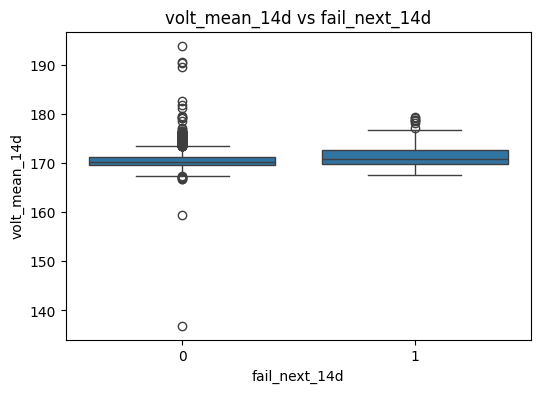

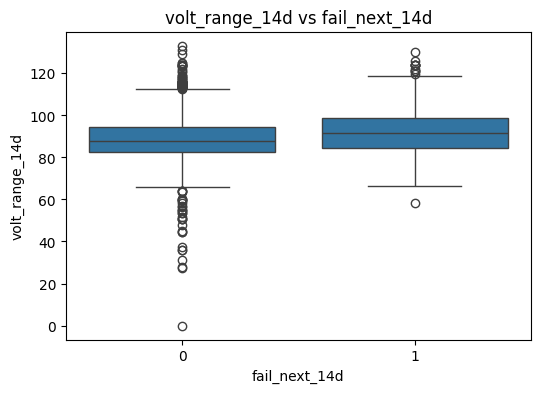

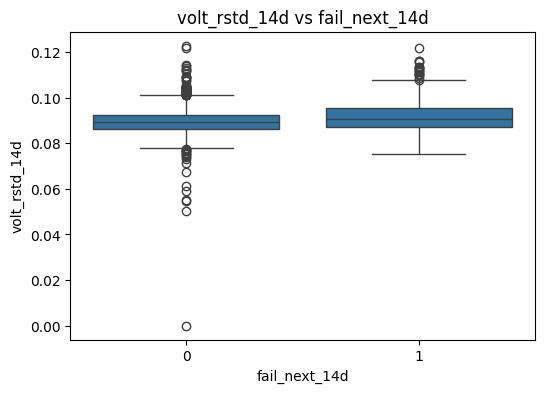

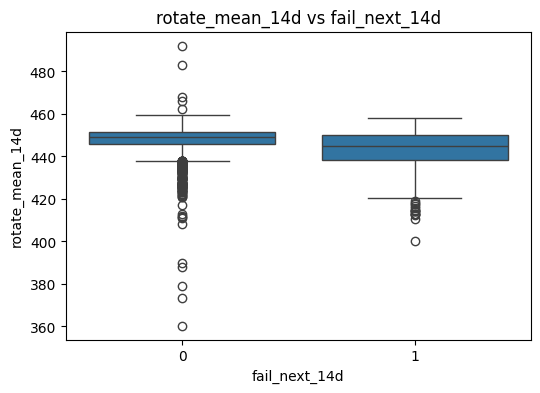

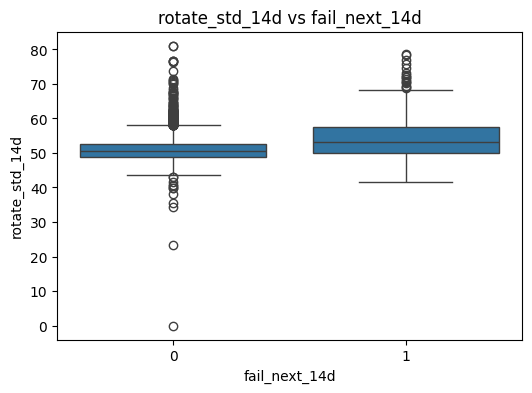

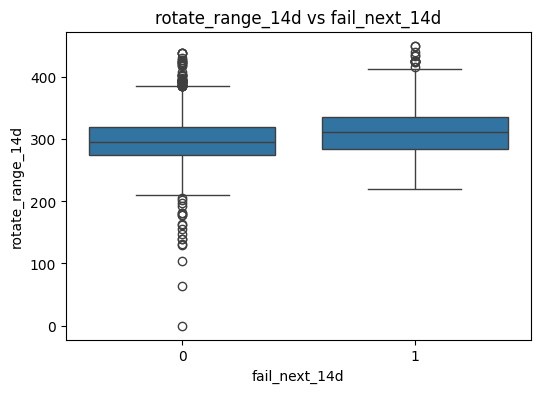

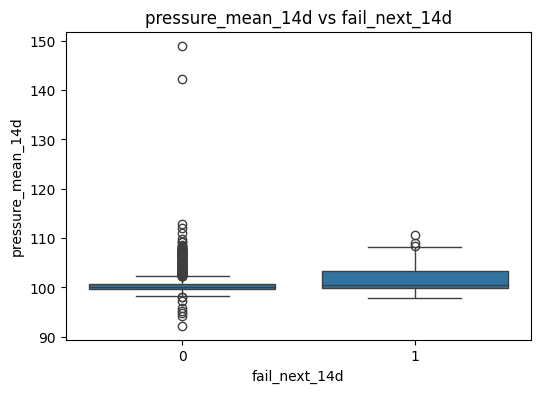

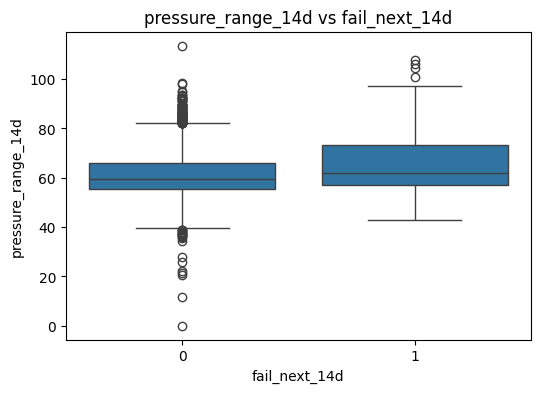

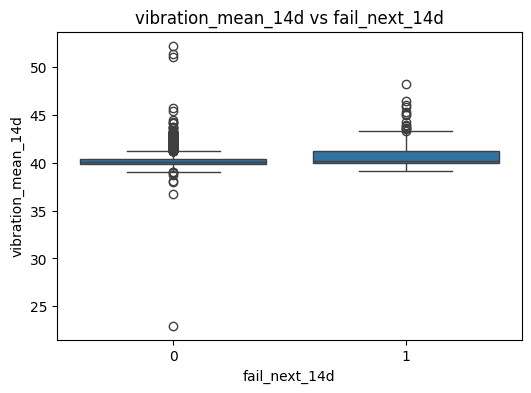

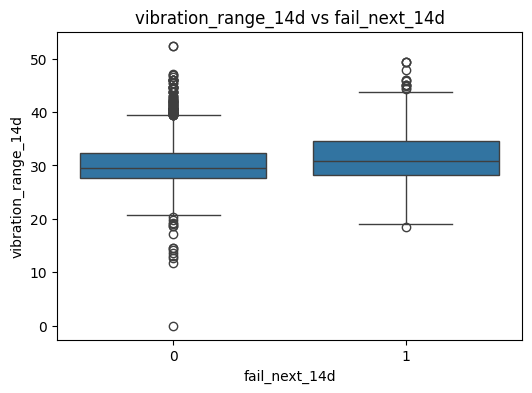

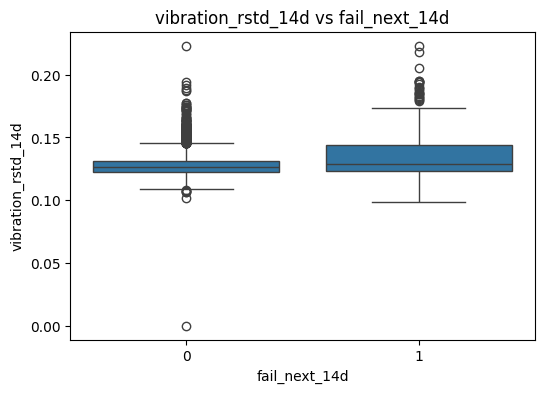

In [19]:
for col in df_model.columns:
  if col != target:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=col, data=df_model.sample(5000, random_state=42))
    plt.title(f"{col} vs {target}")
    plt.show()

In [20]:
for col in df_model.columns:
  if col != target:
    df_model[f"{col}_bin"] = pd.qcut(df_model[col], q=10, duplicates="drop")
    rate = df_model.groupby(f"{col}_bin")[target].mean()
    print(f"\n{col}")
    print(rate)

/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()



volt_mean_14d
volt_mean_14d_bin
(136.878, 169.09]     0.189887
(169.09, 169.504]     0.212578
(169.504, 169.807]    0.204326
(169.807, 170.082]    0.207636
(170.082, 170.361]    0.223821
(170.361, 170.682]    0.225031
(170.682, 171.149]    0.223993
(171.149, 172.168]    0.308823
(172.168, 173.186]    0.429586
(173.186, 223.853]    0.468942
Name: fail_next_14d, dtype: float64

volt_range_14d
volt_range_14d_bin
(-0.001, 78.139]      0.220939
(78.139, 81.639]      0.234711
(81.639, 84.121]      0.215408
(84.121, 86.514]      0.201133
(86.514, 88.768]      0.246489
(88.768, 91.237]      0.263063
(91.237, 93.855]      0.274041
(93.855, 97.603]      0.311414
(97.603, 102.651]     0.343175
(102.651, 139.361]    0.384360
Name: fail_next_14d, dtype: float64

volt_rstd_14d
volt_rstd_14d_bin
(-0.001, 0.0842]    0.214336
(0.0842, 0.0859]    0.218925
(0.0859, 0.0871]    0.228033
(0.0871, 0.0883]    0.228981
(0.0883, 0.0894]    0.223605
(0.0894, 0.0906]    0.231252
(0.0906, 0.092]     0.249321
(0.0

/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()



rotate_mean_14d
rotate_mean_14d_bin
(338.552, 437.153]    0.521036
(437.153, 440.586]    0.491690
(440.586, 445.418]    0.340600
(445.418, 447.378]    0.208800
(447.378, 448.597]    0.191907
(448.597, 449.612]    0.189134
(449.612, 450.581]    0.202511
(450.581, 451.632]    0.184134
(451.632, 453.02]     0.180562
(453.02, 576.924]     0.184248
Name: fail_next_14d, dtype: float64

rotate_std_14d
rotate_std_14d_bin
(-0.001, 47.821]     0.188985
(47.821, 48.804]     0.178187
(48.804, 49.528]     0.188072
(49.528, 50.176]     0.200228
(50.176, 50.87]      0.190652
(50.87, 51.704]      0.200183
(51.704, 53.032]     0.206198
(53.032, 55.764]     0.343888
(55.764, 58.275]     0.489796
(58.275, 114.325]    0.508435
Name: fail_next_14d, dtype: float64

rotate_range_14d
rotate_range_14d_bin
(-0.001, 261.598]     0.191548
(261.598, 272.584]    0.200529
(272.584, 281.195]    0.195304
(281.195, 289.568]    0.214795
(289.568, 298.265]    0.244941
(298.265, 307.501]    0.255347
(307.501, 317.657]   

/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()



pressure_mean_14d
pressure_mean_14d_bin
(76.00399999999999, 99.363]    0.222851
(99.363, 99.626]               0.222018
(99.626, 99.825]               0.233364
(99.825, 100.004]              0.239105
(100.004, 100.185]             0.242187
(100.185, 100.396]             0.222566
(100.396, 100.704]             0.239482
(100.704, 102.533]             0.269946
(102.533, 103.75]              0.388689
(103.75, 153.422]              0.414416
Name: fail_next_14d, dtype: float64

pressure_range_14d
pressure_range_14d_bin
(-0.001, 52.111]     0.232523
(52.111, 54.528]     0.228407
(54.528, 56.242]     0.214701
(56.242, 58.063]     0.204289
(58.063, 59.954]     0.231494
(59.954, 62.359]     0.263557
(62.359, 65.817]     0.240590
(65.817, 71.152]     0.297136
(71.152, 77.186]     0.402182
(77.186, 113.637]    0.379787
Name: fail_next_14d, dtype: float64

vibration_mean_14d
vibration_mean_14d_bin
(22.971999999999998, 39.696]    0.221516
(39.696, 39.83]                 0.207727
(39.83, 39.933]    

/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()
/tmp/ipython-input-1935809638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_model.groupby(f"{col}_bin")[target].mean()


In [21]:
def ks_best_threshold(y_true: np.ndarray, y_proba: np.ndarray, n_bins: int = 200) -> tuple[float, float]:
    """
    Returns (ks_max, threshold_ks).

    Finds the threshold that maximizes the Kolmogorov-Smirnov (KS) statistic
    by evaluating thresholds across probability percentiles.
    """
    # Sort by score
    order = np.argsort(y_proba)
    y_true_sorted = y_true[order]
    y_proba_sorted = y_proba[order]

    # Bins by percentiles (stable)
    qs = np.linspace(0, 1, n_bins + 1)
    thr_list = np.quantile(y_proba_sorted, qs)

    ks_vals = []
    for t in thr_list:
        pred_pos = (y_proba >= t)
        # TPR and FPR
        tp = (pred_pos & (y_true == 1)).sum()
        fn = ((~pred_pos) & (y_true == 1)).sum()
        fp = (pred_pos & (y_true == 0)).sum()
        tn = ((~pred_pos) & (y_true == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        ks_vals.append((t, tpr - fpr))

    # Best KS
    threshold_ks, ks_max = max(ks_vals, key=lambda z: z[1])
    return ks_max, float(threshold_ks)


def clean_outliers_class0_with_ks(
    df: pd.DataFrame,
    features: list[str],
    target: str,
    cap_quantile: float = 0.99
) -> tuple[pd.DataFrame, dict, pd.DataFrame]:
    """
    Winsorizes outliers of class 0 for the given features
    and runs a KS test before vs after to validate distribution consistency.

    Returns:
        df_clean: DataFrame with capped outliers
        caps: dictionary with applied caps (pXX values)
        ks_df: DataFrame with KS test results before vs after (class 0)
    """
    df_clean = df.copy()
    mask0 = df_clean[target] == 0
    df0 = df_clean.loc[mask0, features]

    # Compute caps for class 0
    caps = {col: df0[col].quantile(cap_quantile) for col in features}

    # Save original distributions of class 0
    original_distributions = {col: df0[col].values for col in features}

    # Winsorization only on class 0
    for col, cap in caps.items():
        df_clean.loc[mask0 & (df_clean[col] > cap), col] = cap

    # Distributions after cleaning
    new_distributions = {
        col: df_clean.loc[mask0, col].values for col in features
    }

    # KS test (before vs after, class 0)
    ks_results = []
    for col in features:
        ks_stat, p_val = ks_2samp(original_distributions[col], new_distributions[col])
        ks_results.append({"feature": col, "KS_stat": ks_stat, "p_value": p_val})

    ks_df = pd.DataFrame(ks_results)

    return df_clean, caps, ks_df


# Apply cleaning to df_model
features = [
    col for col in df_model.select_dtypes(include=[np.number]).columns
    if col != target
]

df_model_clean, caps_used, ks_results = clean_outliers_class0_with_ks(
    df_model, features, target, cap_quantile=0.99
)

print("Applied caps (p99 in class 0):")
print(caps_used)

print("\nKS test before vs after (class 0):")
print(ks_results)


Applied caps (p99 in class 0):
{'volt_mean_14d': np.float64(175.6064374628682), 'volt_range_14d': np.float64(115.18045130902001), 'volt_rstd_14d': np.float64(0.10277308760399859), 'rotate_mean_14d': np.float64(456.5130500156701), 'rotate_std_14d': np.float64(63.0588836954756), 'rotate_range_14d': np.float64(394.309525182628), 'pressure_mean_14d': np.float64(107.00619744866196), 'pressure_range_14d': np.float64(86.8017094695261), 'vibration_mean_14d': np.float64(42.73311319311317), 'vibration_range_14d': np.float64(41.79982881601029), 'vibration_rstd_14d': np.float64(0.1601260018490295)}

KS test before vs after (class 0):
                feature   KS_stat       p_value
0         volt_mean_14d  0.010001  3.126401e-28
1        volt_range_14d  0.009865  1.760932e-27
2         volt_rstd_14d  0.010001  3.126401e-28
3       rotate_mean_14d  0.010001  3.126401e-28
4        rotate_std_14d  0.010001  3.126401e-28
5      rotate_range_14d  0.009751  7.374149e-27
6     pressure_mean_14d  0.010001 

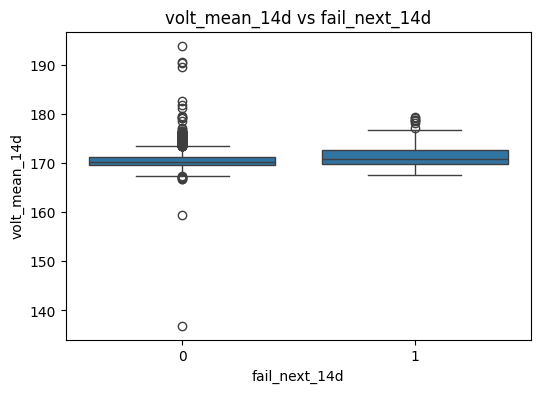

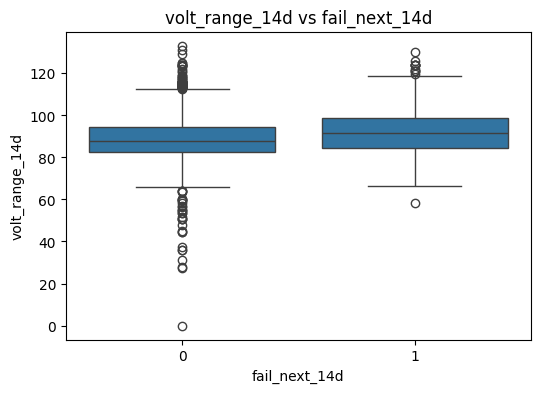

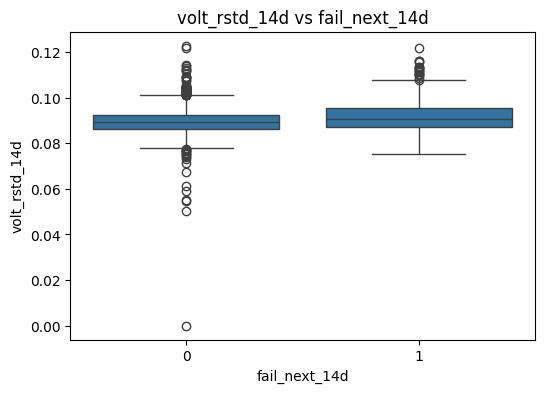

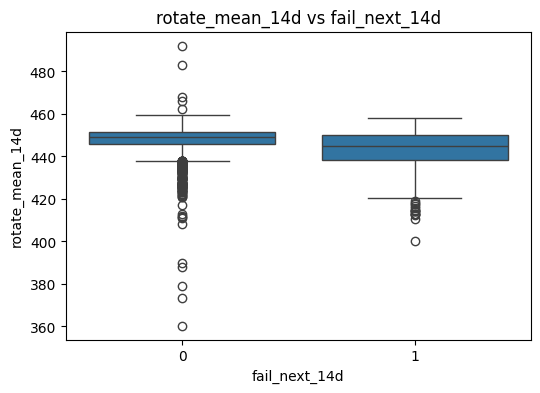

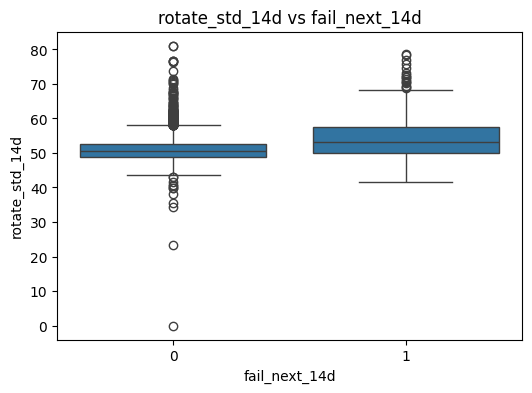

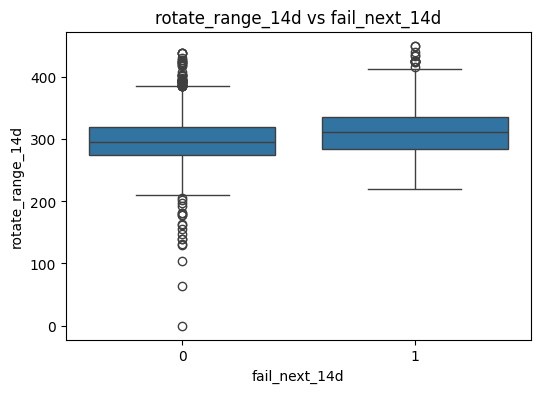

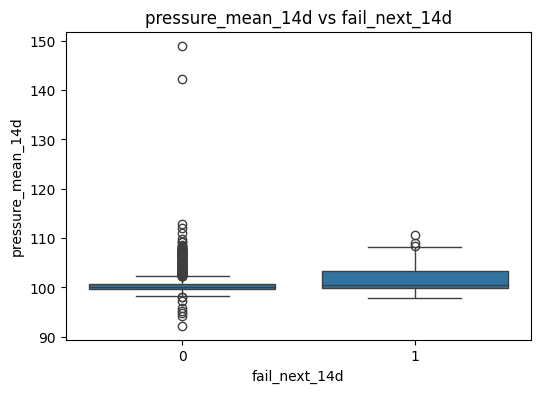

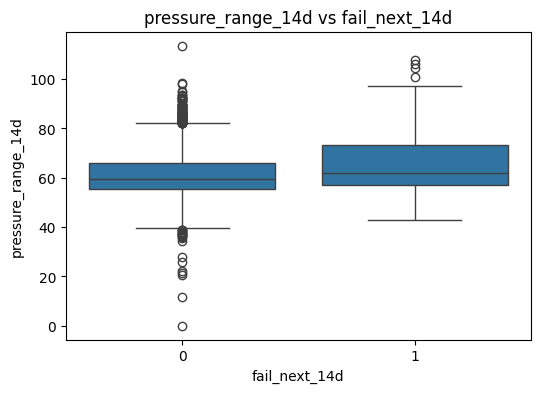

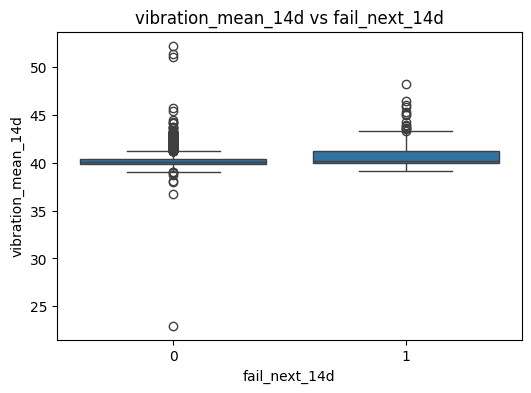

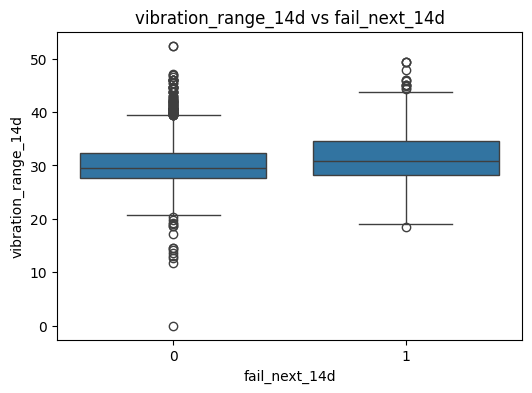

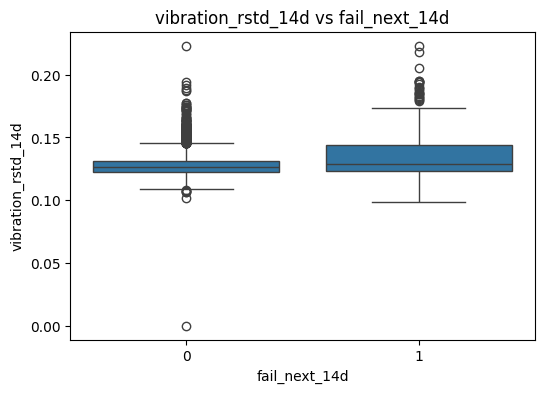

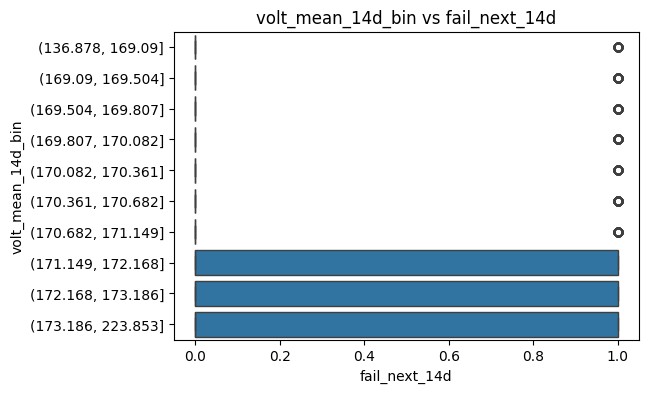

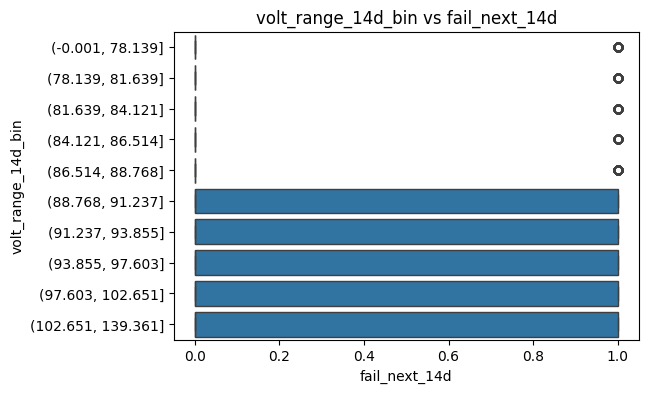

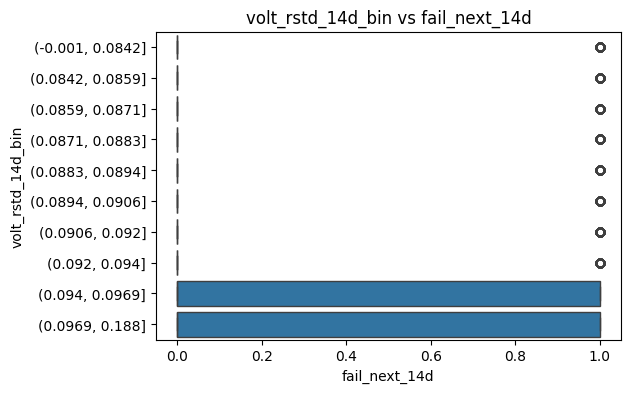

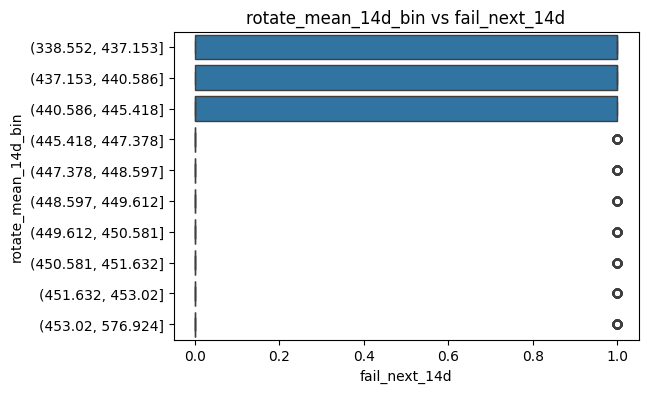

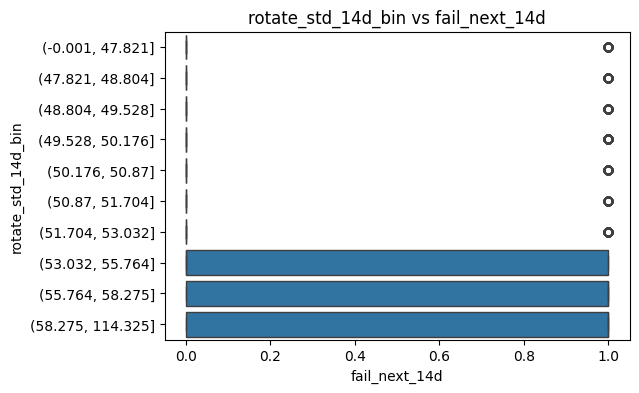

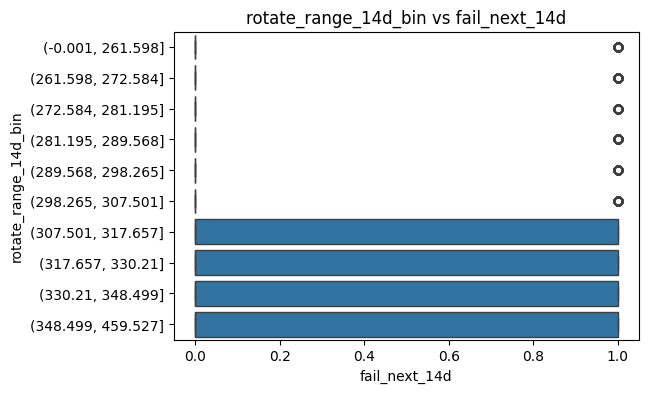

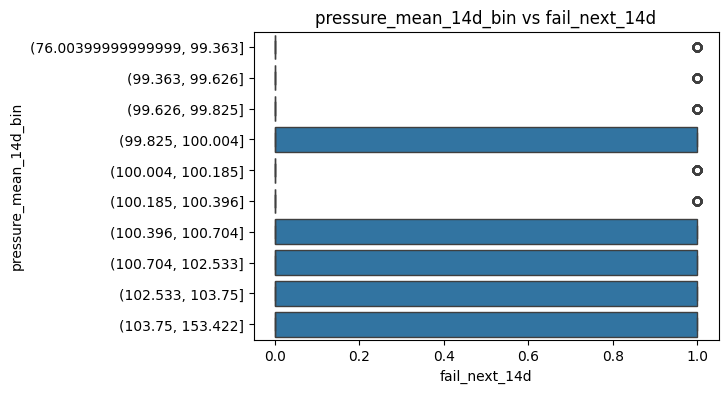

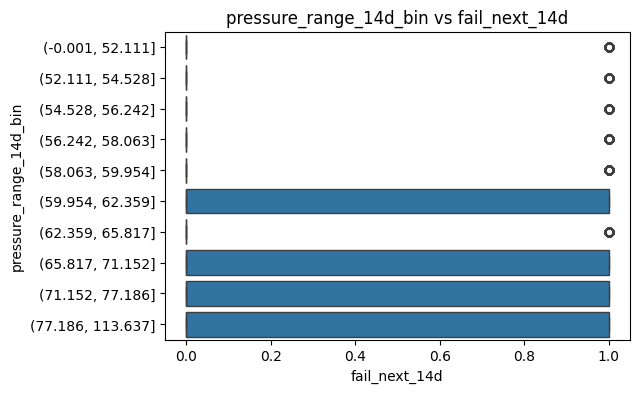

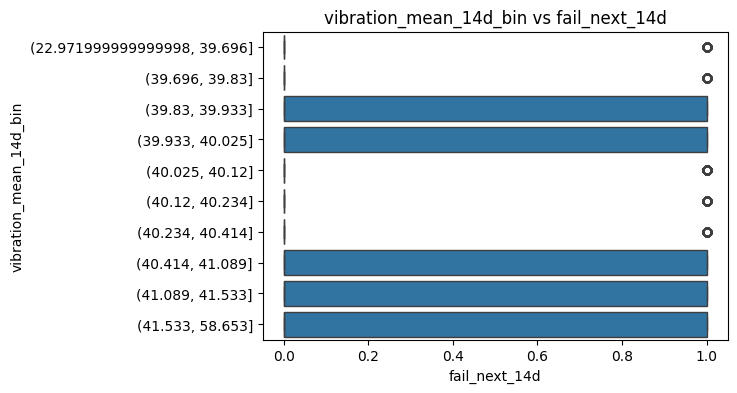

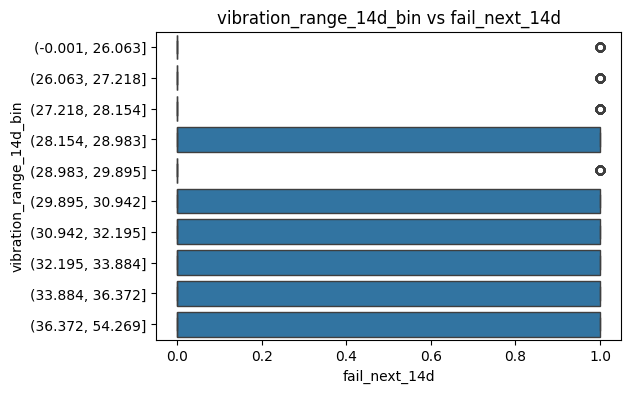

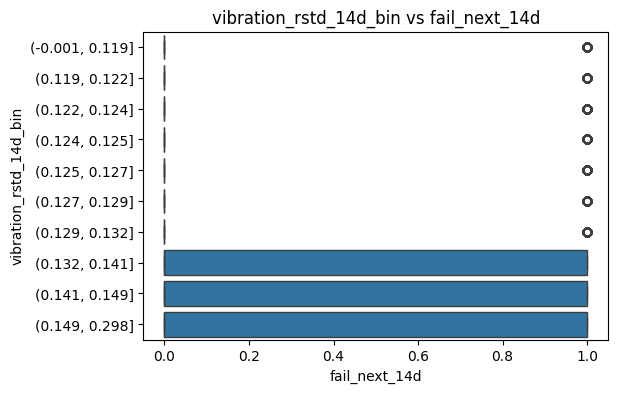

In [22]:
for col in df_model_clean.columns:
  if col != target:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=col, data=df_model.sample(5000, random_state=42))
    plt.title(f"{col} vs {target}")
    plt.show()

##Model training

In [28]:
# =========================================================
# Utilities
# =========================================================
def ks_statistic(y_true: np.ndarray, y_score: np.ndarray) -> float:
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    n_pos = y_true.sum()
    n_neg = len(y_true) - n_pos
    if n_pos == 0 or n_neg == 0:
        return 0.0

    # si todas las probabilidades son iguales, KS = 0
    if np.allclose(y_score, y_score[0]):
        return 0.0

    order = np.argsort(y_score)
    y_sorted = y_true[order]

    cum_pos = np.cumsum(y_sorted) / n_pos
    cum_neg = np.cumsum(1 - y_sorted) / n_neg
    return float(np.max(np.abs(cum_pos - cum_neg)))


def ks_scorer_func(estimator, X, y):
    """Sklearn-compatible scorer (uses predict_proba)."""
    proba = estimator.predict_proba(X)[:, 1]
    return ks_statistic(y, proba)

ks_scorer = make_scorer(ks_scorer_func, needs_proba=False, greater_is_better=True)

def ks_best_threshold(y_true: np.ndarray, y_proba: np.ndarray, n_bins: int = 400) -> tuple[float, float]:
    """Returns (KS_max, threshold_ks)."""
    # Percentile-based bins for stability
    qs = np.linspace(0, 1, n_bins + 1)
    thr_list = np.quantile(y_proba, qs)
    best_ks, best_thr = -1.0, 0.5
    for t in thr_list:
        pred_pos = (y_proba >= t)
        tp = (pred_pos & (y_true == 1)).sum()
        fn = ((~pred_pos) & (y_true == 1)).sum()
        fp = (pred_pos & (y_true == 0)).sum()
        tn = ((~pred_pos) & (y_true == 0)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        ks = tpr - fpr
        if ks > best_ks:
            best_ks, best_thr = ks, float(t)
    return best_ks, best_thr

In [30]:
target = "fail_next_14d"
features = [c for c in df_model_clean.select_dtypes(include=[np.number]).columns if c != target]

# Reemplaza inf por NaN en una sola pasada, sin copias innecesarias
X_full = df_model_clean[features]
X_full = X_full.where(np.isfinite(X_full), np.nan)

y_full = df_model_clean[target].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
)

# =========================================================
# Pipeline and compact hyperparameter grid (L1 + liblinear)
# =========================================================
memory = Memory(location="cache_sklearn", verbose=0)

base_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("logreg", LogisticRegression(
            penalty="l1",
            solver="liblinear",
            class_weight="balanced",
            max_iter=3000,
            tol=1e-5
        )),
    ],
    memory=memory
)

# Grid compacto: solo C (log-spaced corto)
param_grid = {
    "logreg__C": np.array([1e-3, 2e-3, 5e-3, 1e-2, 2e-2])
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring={"roc_auc": "roc_auc", "ks": ks_scorer, "pr": "average_precision"},
    refit="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False,
)

grid.fit(X_train, y_train)

print("\nBest hyperparameters (refit=roc_auc):")
print(grid.best_params_)
print(f"Best CV AUC: {grid.best_score_:.4f}")

# KS y PR-AUC medios directamente del grid (sin re-entrenar)
mean_cv_ks = grid.cv_results_["mean_test_ks"][grid.best_index_]
std_cv_ks  = grid.cv_results_["std_test_ks"][grid.best_index_]
mean_cv_pr = grid.cv_results_["mean_test_pr"][grid.best_index_]
std_cv_pr  = grid.cv_results_["std_test_pr"][grid.best_index_]
print(f"CV KS (mean ± std): {mean_cv_ks:.4f} ± {std_cv_ks:.4f}")
print(f"CV PR-AUC (mean ± std): {mean_cv_pr:.4f} ± {std_cv_pr:.4f}")

# =========================================================
# Holdout evaluation (original test)
# =========================================================
proba_test = grid.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, proba_test)
ks_max, thr_ks = ks_best_threshold(y_test, proba_test)
y_pred_ks = (proba_test >= thr_ks).astype(int)

print("\n=== Holdout Results ===")
print(f"AUC (test): {auc_test:.4f}")
print(f"KS (max) test: {ks_max:.4f} @ threshold={thr_ks:.4f}")
print("Classification Report @ KS threshold:")
print(classification_report(y_test, y_pred_ks, digits=4))

# =========================================================
# Coefficients (no refit redundante)
# =========================================================
best_model = grid.best_estimator_  # ya viene fitted en X_train
coef = best_model.named_steps["logreg"].coef_.ravel()

coef_df = (
    pd.DataFrame({"feature": features, "coef": coef})
      .sort_values(by="coef", key=np.abs, ascending=False)
      .reset_index(drop=True)
)
print("\nCoefficients (sorted by |coef|):")
print(coef_df)

# =============================
# Inspect best model hyperparameters
# =============================
best_logreg = grid.best_estimator_.named_steps["logreg"]

print("\nBest Logistic Regression hyperparameters:")
for k, v in best_logreg.get_params().items():
    print(f"{k}: {v}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



Best hyperparameters (refit=roc_auc):
{'logreg__C': np.float64(0.001)}
Best CV AUC: 0.7885
CV KS (mean ± std): nan ± nan
CV PR-AUC (mean ± std): 0.5551 ± 0.0009

=== Holdout Results ===
AUC (test): 0.7877
KS (max) test: 0.4222 @ threshold=0.3920
Classification Report @ KS threshold:
              precision    recall  f1-score   support

           0     0.9083    0.5813    0.7089    128005
           1     0.4256    0.8410    0.5651     47215

    accuracy                         0.6512    175220
   macro avg     0.6669    0.7111    0.6370    175220
weighted avg     0.7782    0.6512    0.6702    175220


Coefficients (sorted by |coef|):
                feature      coef
0         volt_mean_14d  0.497651
1        rotate_std_14d  0.429067
2       rotate_mean_14d -0.392372
3    vibration_mean_14d  0.373625
4     pressure_mean_14d  0.317639
5    pressure_range_14d  0.223374
6    vibration_rstd_14d  0.173893
7         volt_rstd_14d  0.172708
8   vibration_range_14d  0.068674
9        volt_

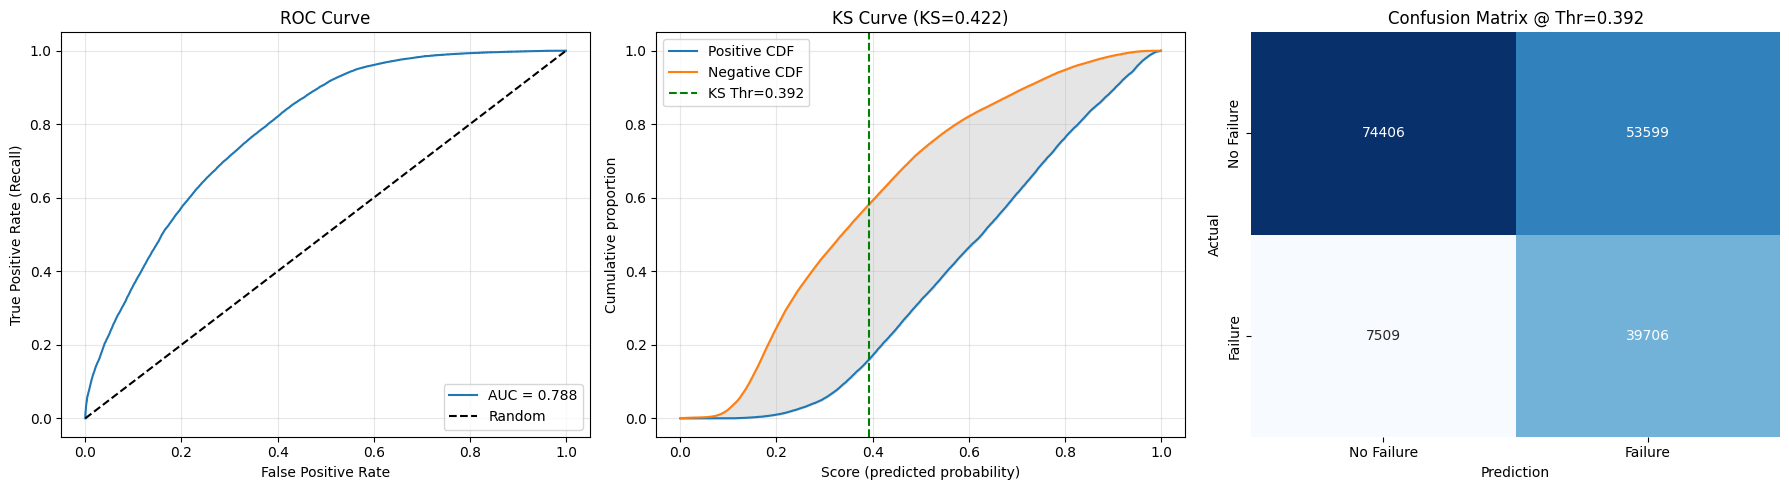

In [25]:
# =============================
# Prepare data
# =============================
mask = ~np.isnan(proba_test)
y_test_plot = y_test[mask]
proba_test_plot = proba_test[mask]
y_pred_ks_plot = (proba_test_plot >= thr_ks).astype(int)

# ROC components
fpr, tpr, thresholds = roc_curve(y_test_plot, proba_test_plot)

# Confusion matrix @ KS threshold
cm = confusion_matrix(y_test_plot, y_pred_ks_plot)

# =============================
# Figure with subplots
# =============================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 1) ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
axes[0].plot([0, 1], [0, 1], "k--", label="Random")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# --- 2) KS Curve
df_scores = (
    pd.DataFrame({"y_true": y_test_plot, "proba": proba_test_plot})
    .sort_values("proba", kind="mergesort")
    .reset_index(drop=True)
)

pos_total = int(df_scores["y_true"].sum())
neg_total = int(len(df_scores) - pos_total)

cum_pos = np.cumsum(df_scores["y_true"].values) / max(pos_total, 1)
cum_neg = np.cumsum((1 - df_scores["y_true"].values)) / max(neg_total, 1)

axes[1].plot(df_scores["proba"].values, cum_pos, label="Positive CDF")
axes[1].plot(df_scores["proba"].values, cum_neg, label="Negative CDF")
axes[1].fill_between(df_scores["proba"].values, cum_pos, cum_neg, color="gray", alpha=0.2)
axes[1].axvline(thr_ks, color="green", linestyle="--", label=f"KS Thr={thr_ks:.3f}")
axes[1].set_title(f"KS Curve (KS={ks_max:.3f})")
axes[1].set_xlabel("Score (predicted probability)")
axes[1].set_ylabel("Cumulative proportion")
axes[1].legend()
axes[1].grid(alpha=0.3)

# --- 3) Confusion Matrix @ KS threshold
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[2],
    xticklabels=["No Failure", "Failure"],
    yticklabels=["No Failure", "Failure"]
)
axes[2].set_xlabel("Prediction")
axes[2].set_ylabel("Actual")
axes[2].set_title(f"Confusion Matrix @ Thr={thr_ks:.3f}")

plt.tight_layout()
plt.show()


##**Baseline model description**

**Model Evaluation – Logistic Regression (L1, liblinear, class-weight balanced)**

The logistic regression model with L1 regularization (liblinear solver, class-weight balanced) was evaluated on the 14-day prediction target.

Key evaluation results:

- **ROC Curve:** The model achieved an AUC of **0.788**, showing moderate discriminative ability between failure and non-failure events.
- **KS Curve:** The maximum KS value of **0.422** at a threshold of 0.393 indicates reasonable separation between the cumulative distributions of positives and negatives.
- **Classification Report (at KS threshold):**
  - Recall (class 1 / failures): **84%**
  - Precision (class 1 / failures): **43%**
  - Accuracy: **65%**
  - The model captures most failures but at the cost of higher false positives.

**Interpretation**

This regularized logistic regression is simple, interpretable, and stable. It prioritizes recall — which is critical in predictive maintenance, where missing a failure is more costly than issuing false alerts.  
The most influential features are related to **voltage (mean, rstd)**, **rotation (mean, std)**, **vibration (mean, rstd)**, and **pressure (mean, range)**, which align with domain intuition about machine degradation.


## **2:1 balanced ratio**

In [26]:
# =============================
# Efficient undersampling (indices-based) on TRAIN ONLY
# =============================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
# ks_scorer, ks_best_threshold must be defined already

def undersample_train_indices(y: np.ndarray, ratio_neg_pos: float, rng_seed: int = 42) -> np.ndarray:
    """
    Return indices to keep after undersampling negatives to reach desired neg/pos ratio on TRAIN ONLY.
    y must be binary {0,1}. This function does NOT shuffle: caller may shuffle if needed.
    """
    y = np.asarray(y).astype(int)
    assert set(np.unique(y)).issubset({0, 1}), "Target must be binary {0,1}."

    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    n_pos = pos_idx.size
    n_neg = neg_idx.size
    current_ratio = n_neg / max(n_pos, 1)

    print(f"Current neg/pos ratio (train): {current_ratio:.3f}  ({n_neg} / {n_pos})")
    print(f"Target neg/pos ratio: {ratio_neg_pos:.3f}")

    if ratio_neg_pos > current_ratio:
        print("Already more balanced than target; returning all training indices (no undersampling).")
        keep_idx = np.arange(y.shape[0])
        return keep_idx

    # negatives to keep
    n_neg_target = int(np.floor(ratio_neg_pos * n_pos))
    rng = np.random.default_rng(rng_seed)
    keep_neg = rng.choice(neg_idx, size=n_neg_target, replace=False)

    # concatenate positives + sampled negatives
    keep_idx = np.concatenate([pos_idx, keep_neg])

    # optional light shuffle to break ordering without copying full arrays later
    rng.shuffle(keep_idx)
    new_ratio = n_neg_target / max(n_pos, 1)
    print(f"New neg/pos ratio (train undersampled): {new_ratio:.3f}  ({n_neg_target} / {n_pos})")
    return keep_idx


# =============================
# Apply undersampling ONLY on (X_train, y_train)
# =============================

# Replace inf with NaN just once (cheap); imputer will handle NaNs downstream
X_train_us = X_train.replace([np.inf, -np.inf], np.nan)
X_test_us  = X_test.replace([np.inf, -np.inf], np.nan)

keep_idx = undersample_train_indices(y_train, ratio_neg_pos=2.0, rng_seed=42)

X_train_us = X_train_us.iloc[keep_idx]
y_train_us = y_train[keep_idx]

# =============================
# Lean Logistic Regression grid (L1 + liblinear only)
# =============================

base_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(max_iter=3000, penalty="l1", solver="liblinear",
                                  class_weight="balanced", tol=1e-5))
])

# Narrow, log-spaced C values (reduce search space)
param_grid_lr = {
    "logreg__C": np.array([1e-3, 2e-3, 5e-3, 1e-2, 2e-2])
}

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_us = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid_lr,
    scoring={"roc_auc": "roc_auc", "ks": ks_scorer, "pr": "average_precision"},
    refit="roc_auc",
    cv=cv_fast,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid_us.fit(X_train_us, y_train_us)

print("\nBest hyperparameters (2:1 undersampled train):")
print(grid_us.best_params_)
print(f"Best CV AUC (2:1): {grid_us.best_score_:.4f}")

# =============================
# Holdout evaluation on ORIGINAL test set
# =============================
proba_test_us_on_orig = grid_us.predict_proba(X_test_us)[:, 1]
auc_test_us_on_orig = roc_auc_score(y_test, proba_test_us_on_orig)
ks_max_us_on_orig, thr_ks_us_on_orig = ks_best_threshold(y_test, proba_test_us_on_orig)

y_pred_ks_us_on_orig = (proba_test_us_on_orig >= thr_ks_us_on_orig).astype(int)

print("\n=== Holdout Results (2:1 undersampled train, evaluated on original test) ===")
print(f"AUC (test): {auc_test_us_on_orig:.4f}")
print(f"KS (max) test: {ks_max_us_on_orig:.4f} @ threshold={thr_ks_us_on_orig:.4f}")
print("Classification Report @ KS threshold:")
print(classification_report(y_test, y_pred_ks_us_on_orig, digits=4))


Current neg/pos ratio (train): 2.711  (512019 / 188861)
Target neg/pos ratio: 2.000
New neg/pos ratio (train undersampled): 2.000  (377722 / 188861)
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



Best hyperparameters (2:1 undersampled train):
{'logreg__C': np.float64(0.001)}
Best CV AUC (2:1): 0.7882

=== Holdout Results (2:1 undersampled train, evaluated on original test) ===
AUC (test): 0.7877
KS (max) test: 0.4222 @ threshold=0.3857
Classification Report @ KS threshold:
              precision    recall  f1-score   support

           0     0.9122    0.5713    0.7026    128005
           1     0.4227    0.8509    0.5648     47215

    accuracy                         0.6466    175220
   macro avg     0.6674    0.7111    0.6337    175220
weighted avg     0.7803    0.6466    0.6654    175220



### **Undersampling Experiment (2:1 on train, evaluated on original test)**

We undersampled the majority class to a **2:1 negative-to-positive ratio** to prioritize sensitivity.  
**Finding:** undersampling **did not materially change AUC/KS** versus the natural-ratio baseline; it slightly **shifted the optimal threshold** and **reduced accuracy** due to more false positives.

#### Metrics (Test Set)
| Model                          | AUC    | KS (max) | KS Threshold | Recall | Precision | Accuracy |
|--------------------------------|--------|----------|--------------|--------|-----------|----------|
| Baseline (natural ratio)       | 0.7877 | 0.4223   | 0.3927       | 84.1%  | 42.6%     | 65.1%    |
| Undersampled (train 2:1)       | 0.7877 | 0.4222   | 0.3857       | 85.1%  | 42.3%     | 64.7%    |

- **Recall** increases marginally (~+1 pp), as intended.  
- **Precision** is essentially unchanged (~42%).  
- **Accuracy** drops slightly (65.1% → 64.7%) from additional false positives.  
- **AUC/KS** remain effectively the same, indicating no gain in ranking power.

#### Recommendation
Given that real-world prevalence is close to **27% failures / 73% non-failures**, maintaining the **natural class ratio** preserves **probability calibration** and avoids unnecessary variance.  
Instead of undersampling, prefer **threshold tuning** (e.g., KS- or cost-based) to reach the desired **recall/precision** trade-off.


##**Explainability (SHAP)**


Waterfall indices and features for test instance 126943:
 idx             feature  feature_value  shap_value  abs_rank
   8  vibration_mean_14d      19.291844    7.215168         1
   0       volt_mean_14d      10.684371    5.407260         2
   3     rotate_mean_14d      -9.015452    3.472082         3
   4      rotate_std_14d       1.904786    0.759781         4
   6   pressure_mean_14d      -1.980533   -0.680759         5
   2       volt_rstd_14d      -3.396868   -0.566619         6
   7  pressure_range_14d      -2.321996   -0.548928         7
   1      volt_range_14d      -3.870314   -0.252435         8
  10  vibration_rstd_14d       1.262703    0.218092         9
   9 vibration_range_14d       1.462705    0.100709        10
   5    rotate_range_14d      -1.494575   -0.000000        11


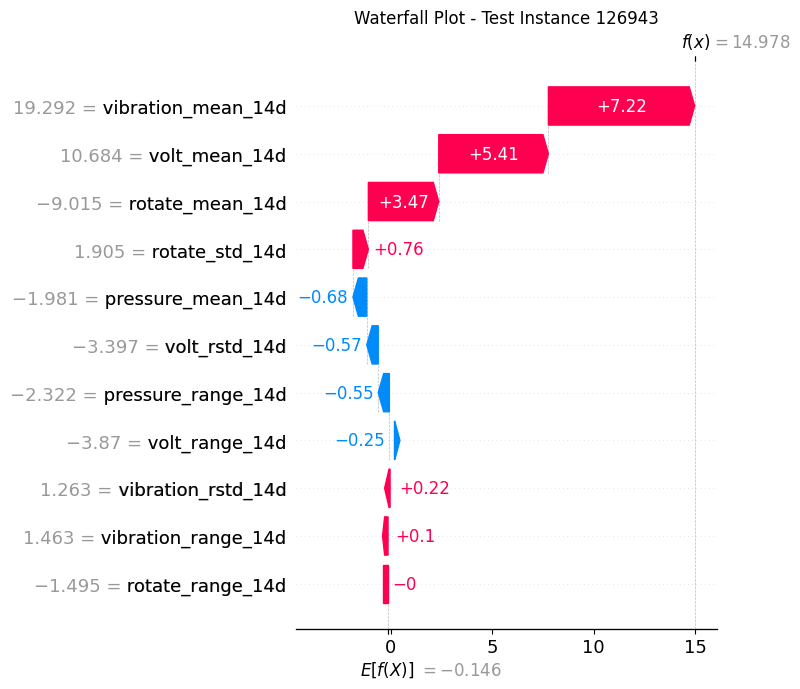


Global SHAP effects on test set (n_features=11):
                feature  mean_shap  mean_pos_shap  mean_neg_shap  frac_positive  mean_abs_shap
0         volt_mean_14d   0.091089       0.228745      -0.137656       0.464171       0.366400
1       rotate_mean_14d  -0.064151       0.128262      -0.192413       0.300468       0.320676
2        rotate_std_14d  -0.057339       0.144986      -0.202325       0.327166       0.347312
3     pressure_mean_14d  -0.051067       0.106787      -0.157854       0.238192       0.264641
4    pressure_range_14d  -0.029731       0.077610      -0.107342       0.359605       0.184952
5         volt_rstd_14d   0.020073       0.073961      -0.053888       0.502397       0.127849
6    vibration_mean_14d   0.007851       0.140478      -0.132627       0.322634       0.273105
7        volt_range_14d   0.002375       0.026588      -0.024214       0.480442       0.050802
8    vibration_rstd_14d  -0.001281       0.065651      -0.066932       0.334402       0.132582


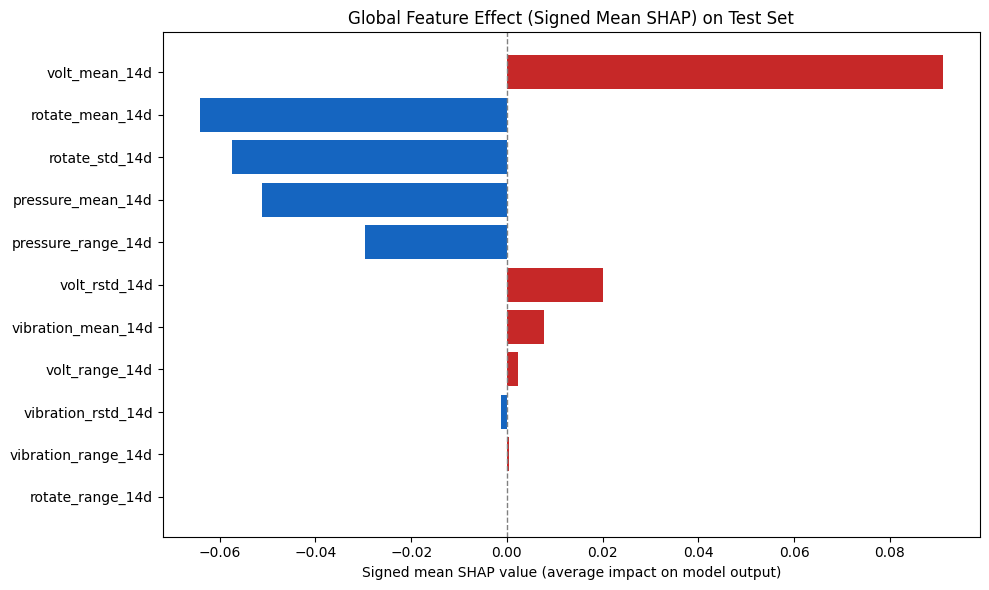

In [37]:
# ============================================
# SHAP Waterfall
# ============================================

# -----------------------------
# 1) Split pipeline components
# -----------------------------
logreg = best_model.named_steps["logreg"]
preproc = best_model[:-1]

# -----------------------------
# 2) Transform train/test sets
# -----------------------------
X_train_tx = preproc.transform(X_train)
X_test_tx  = preproc.transform(X_test)

# Ensure dense matrices
if sparse.issparse(X_train_tx):
    X_train_tx = X_train_tx.toarray()
if sparse.issparse(X_test_tx):
    X_test_tx = X_test_tx.toarray()

# ----------------------------------------
# 3) Retrieve robust feature_names safely
# ----------------------------------------
try:
    feature_names = preproc.get_feature_names_out()
except Exception:
    if "features" in globals() and len(features) == X_train_tx.shape[1]:
        feature_names = np.array(features)
    else:
        feature_names = np.array([f"f_{i}" for i in range(X_train_tx.shape[1])])

# If lengths don’t match (e.g., OneHot expansion), fall back to generic names
if len(feature_names) != X_train_tx.shape[1]:
    feature_names = np.array([f"f_{i}" for i in range(X_train_tx.shape[1])])

# -----------------------------------------
# 4) Use DataFrames so SHAP carries names
# -----------------------------------------
X_train_df = pd.DataFrame(X_train_tx, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_tx,  columns=feature_names)

# ---------------------------------------------------
# 5) Build SHAP explainer (linear model is expected)
# ---------------------------------------------------
mask_base = X_train_df if len(X_train_df) <= 5000 else X_train_df.iloc[:5000]
explainer = shap.Explainer(logreg, masker=shap.maskers.Independent(mask_base))

# Compute SHAP values for the whole test set
shap_test = explainer(X_test_df)

# -------------------------------------------------
# 6) Pick the highest-risk test instance: i_star
# -------------------------------------------------
probs_test = best_model.predict_proba(X_test)[:, 1]
i_star = int(np.argmax(probs_test))

# ---------------------------------------------------------
# 7) Build a single-row Explanation with feature name/data
# ---------------------------------------------------------
single_expl = shap.Explanation(
    values=shap_test.values[i_star],
    base_values=shap_test.base_values[i_star],
    data=X_test_df.iloc[i_star].values,
    feature_names=list(feature_names)
)

# ----------------------------------------------------------------
# 8) Compute the indices that the waterfall will display by |SHAP|
# ----------------------------------------------------------------
# The waterfall orders by absolute contribution.
order = np.argsort(np.abs(single_expl.values))[::-1]

max_display = len(feature_names)

indices_in_plot = order[:max_display]

# Build a table with indices and corresponding info
df_waterfall_indices = pd.DataFrame({
    "idx": indices_in_plot,
    "feature": np.array(single_expl.feature_names)[indices_in_plot],
    "feature_value": np.array(single_expl.data)[indices_in_plot],
    "shap_value": np.array(single_expl.values)[indices_in_plot],
    "abs_rank": np.arange(1, len(indices_in_plot) + 1)  # 1 = largest |SHAP|
})

print(f"\nWaterfall indices and features for test instance {i_star}:")
with pd.option_context("display.max_rows", None, "display.max_colwidth", 100, "display.float_format", "{:,.6f}".format):
    print(df_waterfall_indices.to_string(index=False))

# -----------------------------------------
# 9) Plot the waterfall
# -----------------------------------------
plt.figure(figsize=(9, 7))
shap.plots.waterfall(single_expl, max_display=max_display, show=False)
plt.title(f"Waterfall Plot - Test Instance {i_star}")
plt.tight_layout()


plt.show()

# ============================================
# 10) Global SHAP effect: table + bar plot
# ============================================

# Compute global SHAP statistics on test set
V = shap_test.values  # shape: [n_samples, n_features]

mean_shap      = V.mean(axis=0)                      # signed average impact
mean_pos_shap  = np.clip(V, 0, None).mean(axis=0)    # average of positive contributions
mean_neg_shap  = np.clip(V, None, 0).mean(axis=0)    # average of negative contributions
frac_positive  = (V > 0).mean(axis=0)                # frequency of positive contributions
mean_abs_shap  = np.abs(V).mean(axis=0)              # average absolute impact (common SHAP importance)

df_global = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_shap": mean_shap,
        "mean_pos_shap": mean_pos_shap,
        "mean_neg_shap": mean_neg_shap,
        "frac_positive": frac_positive,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_shap", key=lambda s: np.abs(s), ascending=False)  # order by signed impact magnitude
    .reset_index(drop=True)
)

# Print the global table
print(f"\nGlobal SHAP effects on test set (n_features={len(feature_names)}):")
with pd.option_context("display.max_rows", None, "display.max_colwidth", 100, "display.float_format", "{:,.6f}".format):
    print(df_global.to_string(index=True))

# Bar plot of signed mean SHAP (positive = increases failure risk; negative = decreases)
# Colors: red for positive mean_shap, blue for negative
sorted_feats   = df_global["feature"].values[::-1]     # reverse for top at top in horizontal bar
sorted_signed  = df_global["mean_shap"].values[::-1]

colors = np.where(sorted_signed >= 0, "#c62828", "#1565c0")  # red for positive, blue for negative

plt.figure(figsize=(10, max(6, 0.4*len(sorted_feats))))
plt.barh(sorted_feats, sorted_signed, color=colors)
plt.axvline(0, linestyle="--", linewidth=1, color="gray")
plt.xlabel("Signed mean SHAP value (average impact on model output)")
plt.title("Global Feature Effect (Signed Mean SHAP) on Test Set")
plt.tight_layout()
plt.show()


### **Global SHAP Analysis**

To understand the overall behavior of the logistic regression model, we computed **global SHAP values** across the test set.  
The table below shows the average absolute impact (`mean_abs_shap`) of each feature, which represents its overall importance for the model:

| Feature              | mean_abs_shap |
|-----------------------|---------------|
| volt_mean_14d         | 0.366 |
| rotate_std_14d        | 0.347 |
| rotate_mean_14d       | 0.321 |
| vibration_mean_14d    | 0.273 |
| pressure_mean_14d     | 0.265 |
| pressure_range_14d    | 0.185 |
| vibration_rstd_14d    | 0.133 |
| volt_rstd_14d         | 0.128 |
| vibration_range_14d   | 0.053 |
| volt_range_14d        | 0.051 |
| rotate_range_14d      | 0.000 |

### Key Insights
- The model relies most heavily on **voltage (mean, rstd)**, **rotation (mean, std)**, and **vibration mean** features.  
- **Pressure-related features** also contribute, though to a lesser extent.  
- Some features (e.g., `rotate_range_14d`) show almost no contribution to the predictions.  

This confirms that the model is mainly driven by **voltage and rotation behaviors**, consistent with physical expectations in predictive maintenance.
